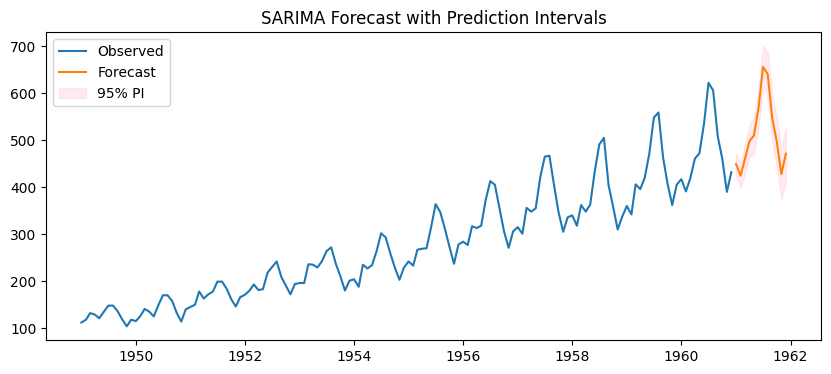

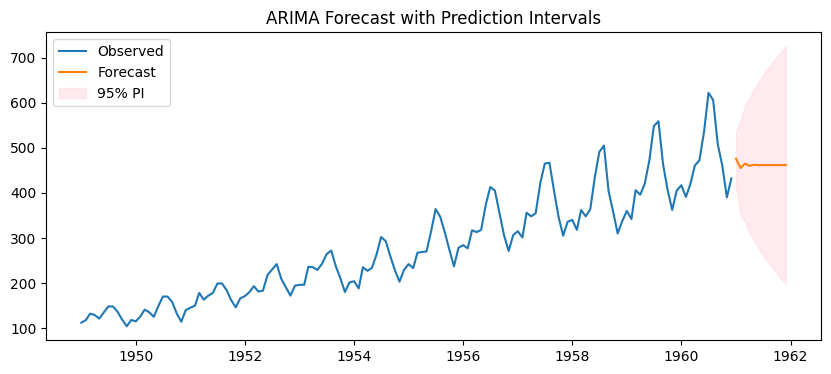

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: Airline Passengers dataset
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                 index_col='Month', parse_dates=True)
series = df['Passengers']

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Forecast 12 steps ahead with prediction intervals
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,4))
plt.plot(series, label='Observed')
plt.plot(mean_forecast, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='95% PI')
plt.legend()
plt.title('SARIMA Forecast with Prediction Intervals')
plt.show()

# Fit ARIMA model
model = SARIMAX(series, order=(1,1,1))
results = model.fit()

# Forecast 12 steps ahead with prediction intervals
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,4))
plt.plot(series, label='Observed')
plt.plot(mean_forecast, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='95% PI')
plt.legend()
plt.title('ARIMA Forecast with Prediction Intervals')
plt.show()

DATA GENERATING PROCESS
True model: y_t = 0.85*y_{t-1} + u_t, where u_t = v_t + 0.7*v_{t-1}
Train size: 400, Test size: 100

FITTED MODEL (AR(1) - misspecified)
Estimated phi: 0.8975 (true: 0.85)
Residual std: 1.1905
Residual mean: -0.0013

BOOTSTRAP PARAMETERS
Number of bootstrap samples: B = 1000
Block length for MBB: b = 16
Forecast horizon: h = 100

PREDICTION INTERVAL RESULTS
Level    Method   Coverage     Width        Points Out  
--------------------------------------------------------------------------------
80%      IID           0.800       6.733          20
80%      MBB           0.820       7.428          18
95%      IID           0.880      10.230          12
95%      MBB           0.910      11.269           9

Expected out at 80%: ~20, at 95%: ~5

KEY INSIGHT:
MBB preserves residual dependence → wider intervals → better coverage
IID ignores dependence → underestimates uncertainty → undercoverage


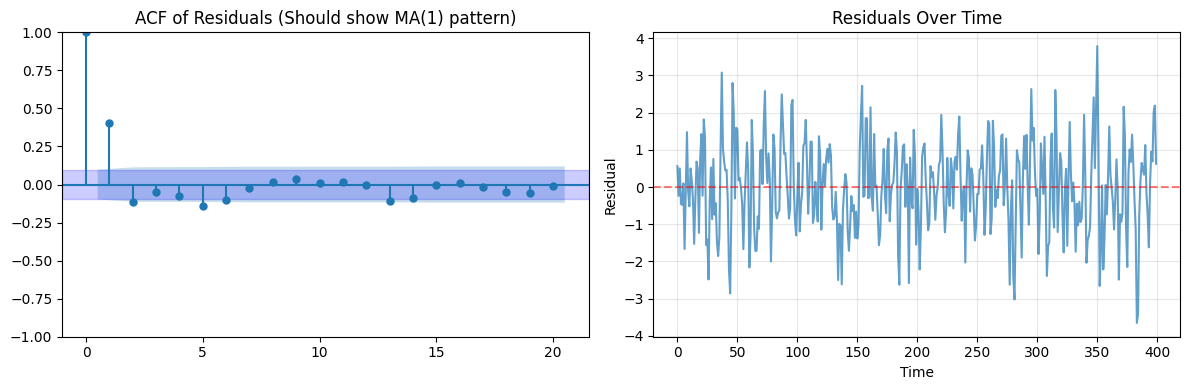

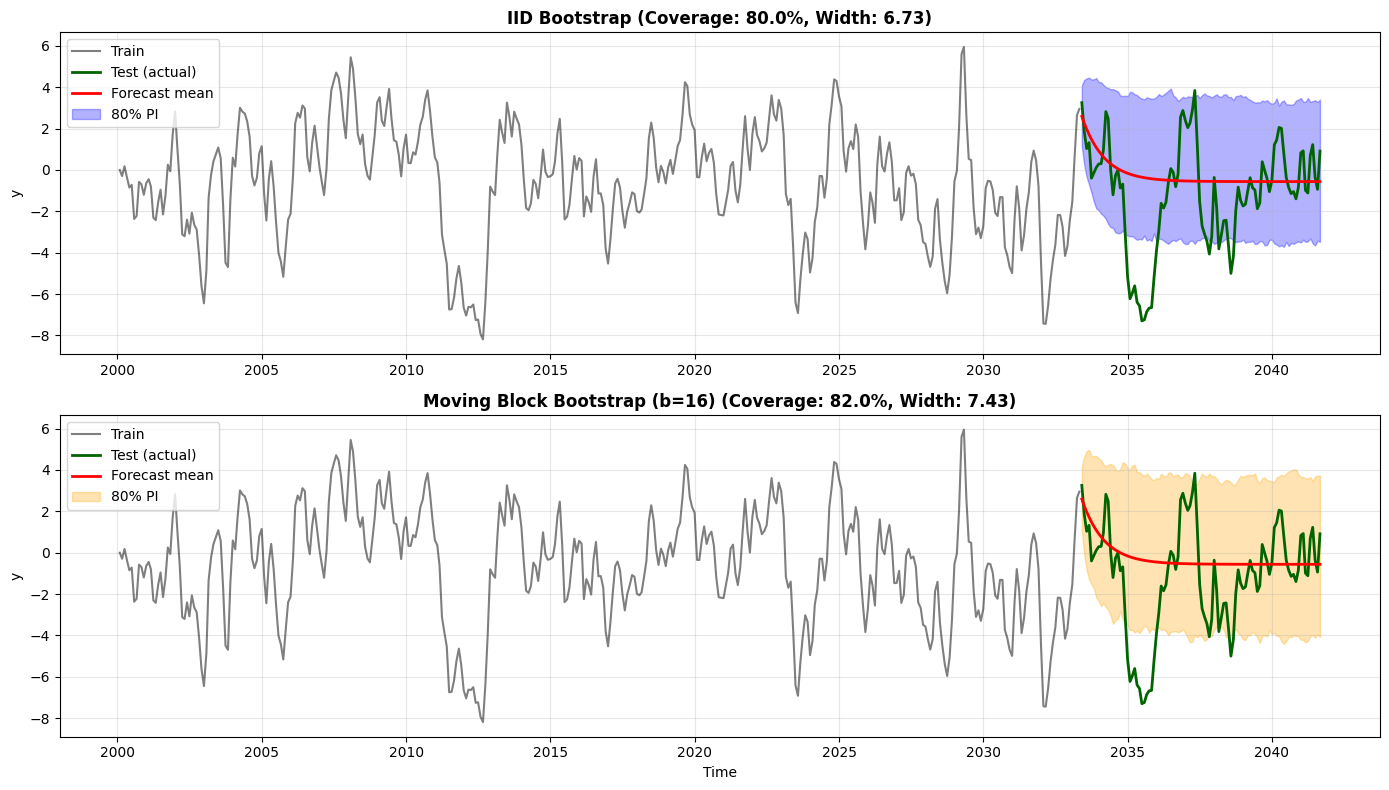

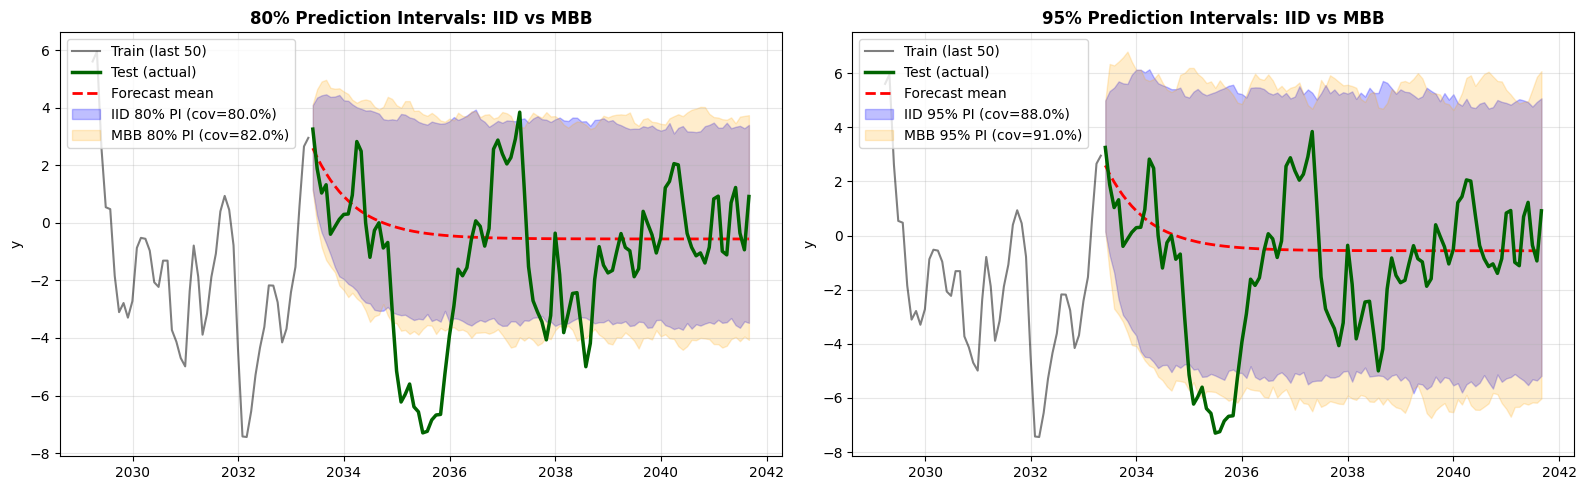

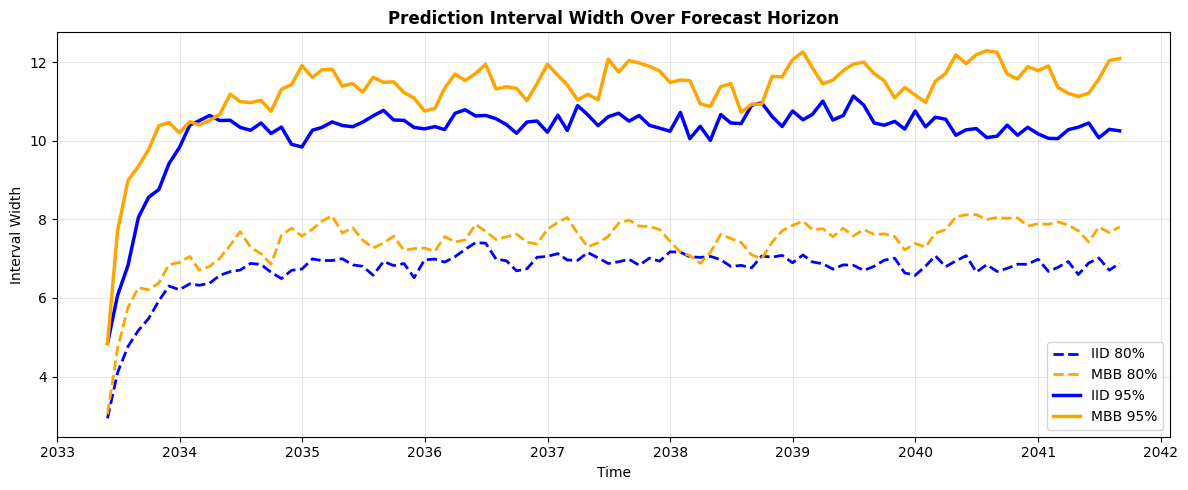

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(7)

# =============================================================================
# 1) Simulate AR(1) process with MA(1) innovations (serially dependent)
#    y_t = phi*y_{t-1} + u_t,   u_t = v_t + theta*v_{t-1},  v_t ~ N(0, 1)
# =============================================================================
n = 500
phi = 0.85
theta = 0.7
v = np.random.normal(0, 1, n+1)
u = v[1:] + theta * v[:-1]              # MA(1) dependence in innovations
y = np.zeros(n)
for t in range(1, n):
    y[t] = phi * y[t-1] + u[t]

y = pd.Series(y, index=pd.date_range("2000-01-01", periods=n, freq="M"))

# Train/test split
T_train = 400
y_train = y.iloc[:T_train]
y_test  = y.iloc[T_train:]
h = len(y_test)

print("="*80)
print("DATA GENERATING PROCESS")
print("="*80)
print(f"True model: y_t = {phi}*y_{{t-1}} + u_t, where u_t = v_t + {theta}*v_{{t-1}}")
print(f"Train size: {T_train}, Test size: {h}")
print()

# =============================================================================
# 2) Fit AR(1) - misspecified since true innovations are MA(1)
# =============================================================================
fit = ARIMA(y_train, order=(1,0,0)).fit()
phi_hat = fit.params['ar.L1']
resid = fit.resid.dropna().values

print("="*80)
print("FITTED MODEL (AR(1) - misspecified)")
print("="*80)
print(f"Estimated phi: {phi_hat:.4f} (true: {phi})")
print(f"Residual std: {resid.std():.4f}")
print(f"Residual mean: {resid.mean():.4f}")
print()

# =============================================================================
# 3) Diagnostic: Show residual autocorrelation (key difference for IID vs MBB)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid, lags=20, ax=axes[0], title="ACF of Residuals")
axes[0].axhspan(-1.96/np.sqrt(len(resid)), 1.96/np.sqrt(len(resid)), 
                alpha=0.2, color='blue', label='95% CI')
axes[0].set_title("ACF of Residuals (Should show MA(1) pattern)")

# Plot residuals over time
axes[1].plot(resid, alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title("Residuals Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residual")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()

# =============================================================================
# 4) Recursive path simulation given a shock sequence
# =============================================================================
def simulate_paths_recursive(phi, y_last, shocks):
    """
    phi: AR(1) coefficient
    y_last: last observed value y_T
    shocks: (B, h) matrix of innovations for each bootstrap path
    returns: (B, h) matrix of simulated y for each path
    """
    B, H = shocks.shape
    Y = np.zeros((B, H))
    Y[:, 0] = phi * y_last + shocks[:, 0]
    for t in range(1, H):
        Y[:, t] = phi * Y[:, t-1] + shocks[:, t]
    return Y

# =============================================================================
# 5) Generate IID vs Block bootstrap resamples
# =============================================================================
def iid_resample(resid, B, h):
    """IID bootstrap: randomly sample residuals with replacement."""
    return np.random.choice(resid, size=(B, h), replace=True)

def mbb_resample(resid, B, h, b=16):
    """Moving Block Bootstrap: sample overlapping blocks of length b."""
    n = len(resid)
    out = np.zeros((B, h))
    for k in range(B):
        seq = []
        while len(seq) < h:
            i = np.random.randint(0, n - b + 1)
            seq.extend(resid[i:i+b])
        out[k, :] = np.array(seq[:h])
    return out

# Choose block length
b = 16  # Long enough to capture MA(1) dependence
B = 1000

print("="*80)
print("BOOTSTRAP PARAMETERS")
print("="*80)
print(f"Number of bootstrap samples: B = {B}")
print(f"Block length for MBB: b = {b}")
print(f"Forecast horizon: h = {h}")
print()

# Generate bootstrap shock matrices
eps_iid = iid_resample(resid, B, h)
eps_mbb = mbb_resample(resid, B, h, b=b)

# Simulate forecast paths
y0 = y_train.iloc[-1]
paths_iid = simulate_paths_recursive(phi_hat, y0, eps_iid)
paths_mbb = simulate_paths_recursive(phi_hat, y0, eps_mbb)

# =============================================================================
# 6) Build prediction intervals and compute coverage/width
# =============================================================================
def intervals(paths, index, level=0.80):
    """Compute prediction intervals from bootstrap paths."""
    a = (1 - level) / 2
    lo = np.quantile(paths, a, axis=0)
    hi = np.quantile(paths, 1 - a, axis=0)
    return pd.Series(lo, index=index), pd.Series(hi, index=index)

mu = pd.Series(fit.get_forecast(steps=h).predicted_mean.values, index=y_test.index)

lo80_iid, hi80_iid = intervals(paths_iid, y_test.index, 0.80)
lo80_mbb, hi80_mbb = intervals(paths_mbb, y_test.index, 0.80)
lo95_iid, hi95_iid = intervals(paths_iid, y_test.index, 0.95)
lo95_mbb, hi95_mbb = intervals(paths_mbb, y_test.index, 0.95)

def cov_width(y_true, lo, hi):
    """Calculate coverage and average width."""
    inside = (y_true >= lo) & (y_true <= hi)
    return float(inside.mean()), float((hi - lo).mean())

c80_iid, w80_iid = cov_width(y_test, lo80_iid, hi80_iid)
c80_mbb, w80_mbb = cov_width(y_test, lo80_mbb, hi80_mbb)
c95_iid, w95_iid = cov_width(y_test, lo95_iid, hi95_iid)
c95_mbb, w95_mbb = cov_width(y_test, lo95_mbb, hi95_mbb)

# Count points outside intervals
out80_iid = np.sum((y_test < lo80_iid) | (y_test > hi80_iid))
out80_mbb = np.sum((y_test < lo80_mbb) | (y_test > hi80_mbb))
out95_iid = np.sum((y_test < lo95_iid) | (y_test > hi95_iid))
out95_mbb = np.sum((y_test < lo95_mbb) | (y_test > hi95_mbb))

# =============================================================================
# 7) Results summary
# =============================================================================
print("="*80)
print("PREDICTION INTERVAL RESULTS")
print("="*80)
print(f"{'Level':<8} {'Method':<8} {'Coverage':<12} {'Width':<12} {'Points Out':<12}")
print("-"*80)
print(f"{'80%':<8} {'IID':<8} {c80_iid:>10.3f}  {w80_iid:>10.3f}  {out80_iid:>10d}")
print(f"{'80%':<8} {'MBB':<8} {c80_mbb:>10.3f}  {w80_mbb:>10.3f}  {out80_mbb:>10d}")
print(f"{'95%':<8} {'IID':<8} {c95_iid:>10.3f}  {w95_iid:>10.3f}  {out95_iid:>10d}")
print(f"{'95%':<8} {'MBB':<8} {c95_mbb:>10.3f}  {w95_mbb:>10.3f}  {out95_mbb:>10d}")
print()
print(f"Expected out at 80%: ~{int(0.20 * h)}, at 95%: ~{int(0.05 * h)}")
print()
print("KEY INSIGHT:")
print("MBB preserves residual dependence → wider intervals → better coverage")
print("IID ignores dependence → underestimates uncertainty → undercoverage")
print("="*80)

# =============================================================================
# 8) Visualizations: Side-by-side comparison
# =============================================================================

# Plot 1: 80% intervals comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Top: IID
axes[0].plot(y_train.index, y_train.values, color="black", alpha=0.5, label="Train")
axes[0].plot(y_test.index, y_test.values, color="darkgreen", lw=2, label="Test (actual)")
axes[0].plot(mu.index, mu.values, color="red", lw=2, label="Forecast mean")
axes[0].fill_between(lo80_iid.index, lo80_iid.values, hi80_iid.values, 
                      alpha=0.3, color="blue", label="80% PI")
axes[0].set_title(f"IID Bootstrap (Coverage: {c80_iid:.1%}, Width: {w80_iid:.2f})", fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel("y")

# Bottom: MBB
axes[1].plot(y_train.index, y_train.values, color="black", alpha=0.5, label="Train")
axes[1].plot(y_test.index, y_test.values, color="darkgreen", lw=2, label="Test (actual)")
axes[1].plot(mu.index, mu.values, color="red", lw=2, label="Forecast mean")
axes[1].fill_between(lo80_mbb.index, lo80_mbb.values, hi80_mbb.values, 
                      alpha=0.3, color="orange", label="80% PI")
axes[1].set_title(f"Moving Block Bootstrap (b={b}) (Coverage: {c80_mbb:.1%}, Width: {w80_mbb:.2f})", 
                  fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel("y")
axes[1].set_xlabel("Time")

plt.tight_layout()

# Plot 2: Overlaid comparison (both 80% and 95%)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 80% comparison
axes[0].plot(y_train.iloc[-50:], color="black", alpha=0.5, label="Train (last 50)")
axes[0].plot(y_test, color="darkgreen", lw=2.5, label="Test (actual)", zorder=10)
axes[0].plot(mu, color="red", lw=2, label="Forecast mean", linestyle='--')
axes[0].fill_between(lo80_iid.index, lo80_iid.values, hi80_iid.values, 
                      alpha=0.25, color="blue", label=f"IID 80% PI (cov={c80_iid:.1%})")
axes[0].fill_between(lo80_mbb.index, lo80_mbb.values, hi80_mbb.values, 
                      alpha=0.2, color="orange", label=f"MBB 80% PI (cov={c80_mbb:.1%})")
axes[0].set_title("80% Prediction Intervals: IID vs MBB", fontsize=12, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel("y")

# 95% comparison
axes[1].plot(y_train.iloc[-50:], color="black", alpha=0.5, label="Train (last 50)")
axes[1].plot(y_test, color="darkgreen", lw=2.5, label="Test (actual)", zorder=10)
axes[1].plot(mu, color="red", lw=2, label="Forecast mean", linestyle='--')
axes[1].fill_between(lo95_iid.index, lo95_iid.values, hi95_iid.values, 
                      alpha=0.25, color="blue", label=f"IID 95% PI (cov={c95_iid:.1%})")
axes[1].fill_between(lo95_mbb.index, lo95_mbb.values, hi95_mbb.values, 
                      alpha=0.2, color="orange", label=f"MBB 95% PI (cov={c95_mbb:.1%})")
axes[1].set_title("95% Prediction Intervals: IID vs MBB", fontsize=12, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel("y")

plt.tight_layout()

# Plot 3: Width comparison over forecast horizon
fig, ax = plt.subplots(figsize=(12, 5))
width_iid_80 = hi80_iid - lo80_iid
width_mbb_80 = hi80_mbb - lo80_mbb
width_iid_95 = hi95_iid - lo95_iid
width_mbb_95 = hi95_mbb - lo95_mbb

ax.plot(width_iid_80.index, width_iid_80.values, label="IID 80%", color="blue", linestyle='--', lw=2)
ax.plot(width_mbb_80.index, width_mbb_80.values, label="MBB 80%", color="orange", linestyle='--', lw=2)
ax.plot(width_iid_95.index, width_iid_95.values, label="IID 95%", color="blue", lw=2.5)
ax.plot(width_mbb_95.index, width_mbb_95.values, label="MBB 95%", color="orange", lw=2.5)
ax.set_title("Prediction Interval Width Over Forecast Horizon", fontsize=12, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Interval Width")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Train size: 216, Test size: 48, Seasonal period m=12
Residual std: 27.6391, Residual mean: 0.5361
Block length b=6, Bootstrap samples B=500

Computing bootstrap prediction intervals...
Processing iid...
Processing mbb...
Processing circular...
Processing stationary...
Processing wild...

PREDICTION INTERVAL SUMMARY (seasonal period m=12, block length b=6)
Method       80% Cov    80% Width    Out(80%)   95% Cov    95% Width    Out(95%)  
--------------------------------------------------------------------------------
iid             0.750        2.26        12       0.854        3.70         7
mbb             0.729        2.19        13       0.896        3.58         5
circular        0.729        2.22        13       0.833        3.58         8
stationary      0.729        2.15        13       0.917        3.64         4
wild            0.708        2.20        14       0.875        3.72         6

Total test points: 48
Expected outside 80% interval: ~9
Expected outside 95% interval: 

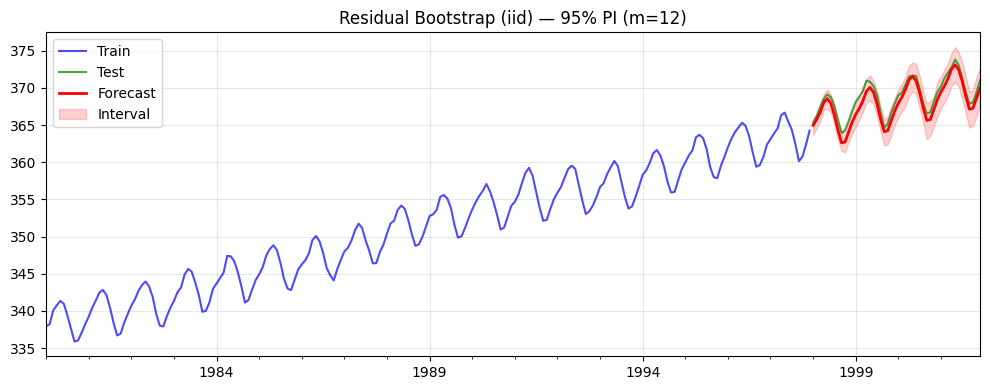

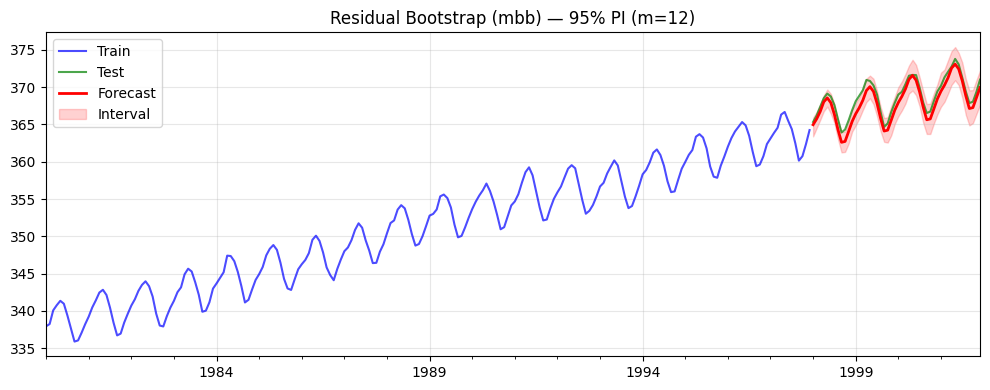

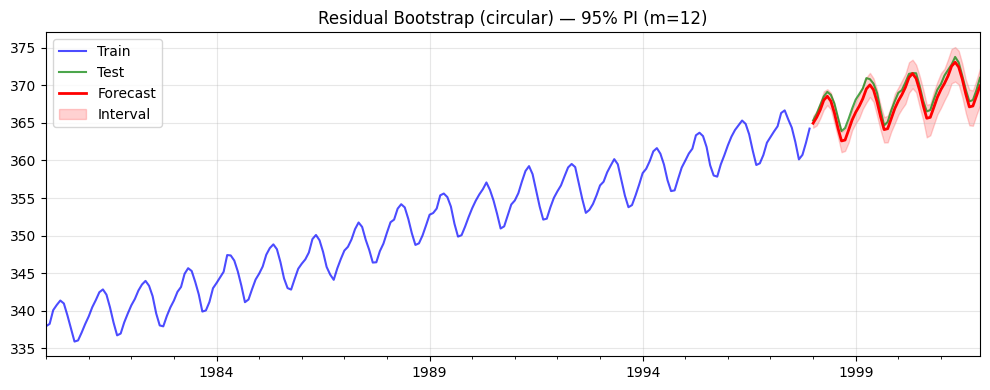

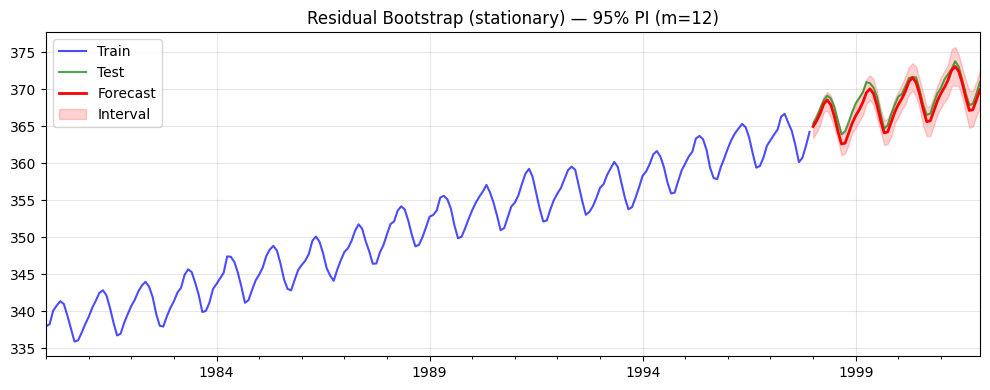

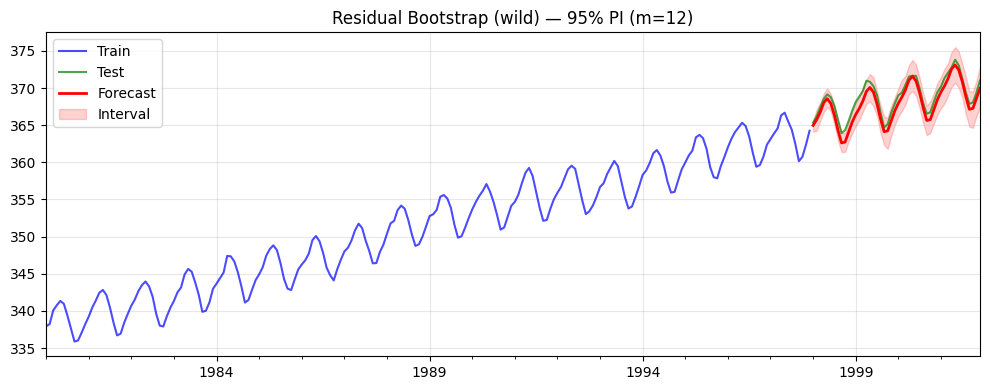

In [36]:
# pip install statsmodels numpy pandas matplotlib

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ----------------------------
# Utilities
# ----------------------------
def pick_block_length(n, rule="cube_root"):
    """Simple rule-of-thumb for block length."""
    if rule == "cube_root":
        return max(2, int(round(n ** (1/3))))
    return max(2, int(round(np.sqrt(n))))

def moving_block_bootstrap(eps, size, b):
    """MBB: draw overlapping blocks of fixed length b and concatenate."""
    n = len(eps)
    out = []
    while len(out) < size:
        i = np.random.randint(0, n - b + 1)
        out.extend(eps[i:i+b])
    return np.asarray(out[:size])

def circular_block_bootstrap(eps, size, b):
    """Circular MBB: blocks wrap around the end."""
    n = len(eps)
    out = []
    while len(out) < size:
        i = np.random.randint(0, n)  # starting index anywhere
        idx = (np.arange(i, i+b) % n)
        out.extend(eps[idx])
    return np.asarray(out[:size])

def stationary_bootstrap(eps, size, b):
    """Politis–Romano stationary bootstrap.
    Each step: with prob p=1/b start a new block at random position, else continue previous.
    """
    n = len(eps)
    p = 1.0 / b
    out = np.empty(size)
    # initial start
    j = np.random.randint(0, n)
    out[0] = eps[j]
    for t in range(1, size):
        if np.random.rand() < p:
            j = np.random.randint(0, n)  # start new block
        else:
            j = (j + 1) % n              # continue block (wrap)
        out[t] = eps[j]
    return out

def wild_bootstrap(eps, size, scheme="rademacher"):
    """Wild bootstrap for heteroskedastic errors: multiply by random weights."""
    base = np.random.choice(eps, size=size, replace=True)
    if scheme == "rademacher":
        w = np.random.choice([-1, 1], size=size)  # mean 0, var 1
    else:
        # Mammen's two-point distribution
        # probs chosen so E[W]=0, Var[W]=1
        p = (np.sqrt(5) + 1) / (2 * np.sqrt(5))
        w = np.where(np.random.rand(size) < p,
                     (1 - np.sqrt(5)) / 2,
                     (1 + np.sqrt(5)) / 2)
    return base * w

def coverage_and_width(y_true, lo, hi):
    inside = (y_true >= lo) & (y_true <= hi)
    return float(inside.mean()), float((hi - lo).mean())

def plot_forecast(y_tr, y_te, mean, lo, hi, title):
    plt.figure(figsize=(10,4))
    y_tr.plot(label="Train", color='blue', alpha=0.7)
    y_te.plot(label="Test", color='green', alpha=0.7)
    mean.plot(label="Forecast", linewidth=2, color='red')
    plt.fill_between(lo.index, lo.values, hi.values, alpha=0.18, label="Interval", color='red')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# ----------------------------
# Data: Monthly CO2 (real, built-in)
# ----------------------------
co2w = sm.datasets.co2.load_pandas().data['co2']
y = co2w.resample('MS').mean().interpolate()
y = y['1980-01-01':'2004-12-01']

# CHANGE THESE TO EXPERIMENT
m = 12  # seasonal period (try 2, 6, 12)
train_end = '1997-12-01'  # earlier split = longer test period for better coverage estimates

y_train = y[:train_end]
y_test  = y[pd.Timestamp(train_end) + pd.DateOffset(months=1):]
h = len(y_test)

print(f"Train size: {len(y_train)}, Test size: {len(y_test)}, Seasonal period m={m}")

# ----------------------------
# Baseline model: SARIMA
# ----------------------------
model = SARIMAX(
    y_train, order=(1,1,1), seasonal_order=(0,1,1,m),
    enforce_stationarity=False, enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=100)
fc = res.get_forecast(steps=h)
mu = fc.predicted_mean
resid = res.resid.dropna().values

print(f"Residual std: {resid.std():.4f}, Residual mean: {resid.mean():.4f}")

# ----------------------------
# Bootstrap engines
# ----------------------------
np.random.seed(123)
B = 500  # increased for more stable quantiles
b = pick_block_length(len(resid))

print(f"Block length b={b}, Bootstrap samples B={B}")

def make_paths(method="mbb", B=500, h=24):
    """Generate bootstrap forecast paths."""
    paths = np.zeros((B, h))
    for k in range(B):
        if method == "iid":
            eps = np.random.choice(resid, size=h, replace=True)
        elif method == "mbb":
            eps = moving_block_bootstrap(resid, h, b)
        elif method == "circular":
            eps = circular_block_bootstrap(resid, h, b)
        elif method == "stationary":
            eps = stationary_bootstrap(resid, h, b)
        elif method == "wild":
            eps = wild_bootstrap(resid, h, scheme="rademacher")
        else:
            raise ValueError("Unknown method")
        
        # Simulate forecast path
        sim_path = res.simulate(
            nsimulations=h,
            measurement_shocks=eps,
            anchor='end',
            initial_state=res.predicted_state[:, -1]
        )
        paths[k, :] = sim_path
    return paths

def intervals_from_paths(paths, index, level=0.95):
    """Compute prediction intervals from bootstrap paths."""
    alpha = 1 - level
    lo = np.quantile(paths, alpha/2, axis=0)
    hi = np.quantile(paths, 1 - alpha/2, axis=0)
    return pd.Series(lo, index=index), pd.Series(hi, index=index)


# ----------------------------
# Build PIs for multiple methods
# ----------------------------
methods = ["iid", "mbb", "circular", "stationary", "wild"]
results = {}

print("\n" + "="*80)
print("Computing bootstrap prediction intervals...")
print("="*80)

for meth in methods:
    print(f"Processing {meth}...")
    paths = make_paths(method=meth, B=B, h=h)
    
    lo80, hi80 = intervals_from_paths(paths, mu.index, level=0.80)
    lo95, hi95 = intervals_from_paths(paths, mu.index, level=0.95)
    
    c80, w80 = coverage_and_width(y_test, lo80, hi80)
    c95, w95 = coverage_and_width(y_test, lo95, hi95)
    
    # Count points outside
    outside_80 = np.sum((y_test < lo80) | (y_test > hi80))
    outside_95 = np.sum((y_test < lo95) | (y_test > hi95))
    
    results[meth] = dict(
        lo80=lo80, hi80=hi80, lo95=lo95, hi95=hi95, 
        c80=c80, w80=w80, c95=c95, w95=w95,
        out80=outside_80, out95=outside_95
    )
    
    # Plot 95% (more interesting than 80%)
    title = f"Residual Bootstrap ({meth}) — 95% PI (m={m})"
    plot_forecast(y_train, y_test, mu, lo95, hi95, title)

# ----------------------------
# Print summary table
# ----------------------------
print("\n" + "="*80)
print(f"PREDICTION INTERVAL SUMMARY (seasonal period m={m}, block length b={b})")
print("="*80)
print(f"{'Method':<12} {'80% Cov':<10} {'80% Width':<12} {'Out(80%)':<10} {'95% Cov':<10} {'95% Width':<12} {'Out(95%)':<10}")
print("-"*80)
for meth in methods:
    r = results[meth]
    print(f"{meth:<12} {r['c80']:>8.3f}  {r['w80']:>10.2f}  {r['out80']:>8d}    {r['c95']:>8.3f}  {r['w95']:>10.2f}  {r['out95']:>8d}")

print("\n" + "="*80)
print(f"Total test points: {len(y_test)}")
print(f"Expected outside 80% interval: ~{int(0.20 * len(y_test))}")
print(f"Expected outside 95% interval: ~{int(0.05 * len(y_test))}")
print("="*80)
print("\nNOTE: With only", len(y_test), "test points, coverage estimates have high variance.")
print("      Try earlier train_end (e.g., '1995-12-01') for longer test period.")
print("="*80)

plt.show()

Calibrated quantiles: 80%=1.584, 95%=2.081


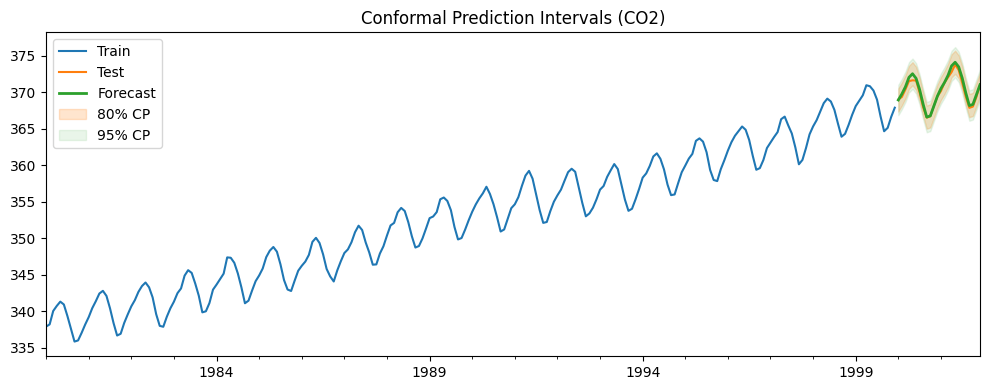

80% PI coverage=1.000, width=3.168
95% PI coverage=1.000, width=4.163


In [38]:
# Conformal Prediction 
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ========== 1. Data: CO2 monthly (real) ==========
co2 = sm.datasets.co2.load_pandas().data['co2'].resample('MS').mean().interpolate()
y = co2['1980-01-01':'2004-12-01']
y_train = y[:'1999-12-01']
y_test = y['2000-01-01':]
m = 12

# ========== 2. Split training into model/calibration ==========
cut = int(len(y_train)*0.75)
train_model, calib = y_train.iloc[:cut], y_train.iloc[cut:]

# ========== 3. Fit SARIMA ==========
model = SARIMAX(train_model, order=(1,1,1), seasonal_order=(0,1,1,m),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# ========== 4. Predict on calibration window & collect errors ==========
fc_cal = res.get_prediction(start=calib.index[0], end=calib.index[-1]).predicted_mean
abs_err = (calib - fc_cal).abs()

# Quantiles for 80% and 95%
q80 = abs_err.quantile(0.8)
q95 = abs_err.quantile(0.95)
print(f"Calibrated quantiles: 80%={q80:.3f}, 95%={q95:.3f}")

# ========== 5. Refit on full training & forecast horizon ==========
model_full = SARIMAX(y_train, order=(1,1,1), seasonal_order=(0,1,1,m),
                     enforce_stationarity=False, enforce_invertibility=False)
res_full = model_full.fit(disp=False)
fc_mean = res_full.get_forecast(steps=len(y_test)).predicted_mean

# ========== 6. Build conformal intervals ==========
lo80, hi80 = fc_mean - q80, fc_mean + q80
lo95, hi95 = fc_mean - q95, fc_mean + q95

# ========== 7. Plot ==========
plt.figure(figsize=(10,4))
y_train.plot(label="Train")
y_test.plot(label="Test")
fc_mean.plot(label="Forecast", lw=2)
plt.fill_between(lo80.index, lo80, hi80, alpha=0.2, color="C1", label="80% CP")
plt.fill_between(lo95.index, lo95, hi95, alpha=0.1, color="C2", label="95% CP")
plt.title("Conformal Prediction Intervals (CO2)")
plt.legend()
plt.tight_layout()
plt.show()

# ========== 8. Evaluate coverage ==========
def cov_width(y_true, lo, hi):
    inside = (y_true>=lo)&(y_true<=hi)
    return inside.mean(), (hi-lo).mean()

for name,(lo,hi) in {"80":(lo80,hi80),"95":(lo95,hi95)}.items():
    c,w = cov_width(y_test,lo,hi)
    print(f"{name}% PI coverage={c:.3f}, width={w:.3f}")


80% coverage=0.958, mean width=1.848
95% coverage=1.000, mean width=2.826


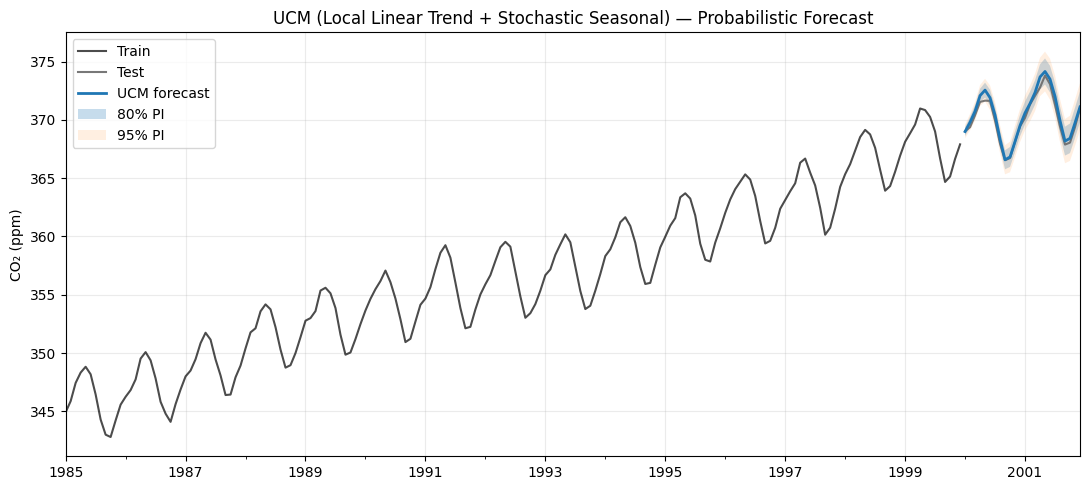

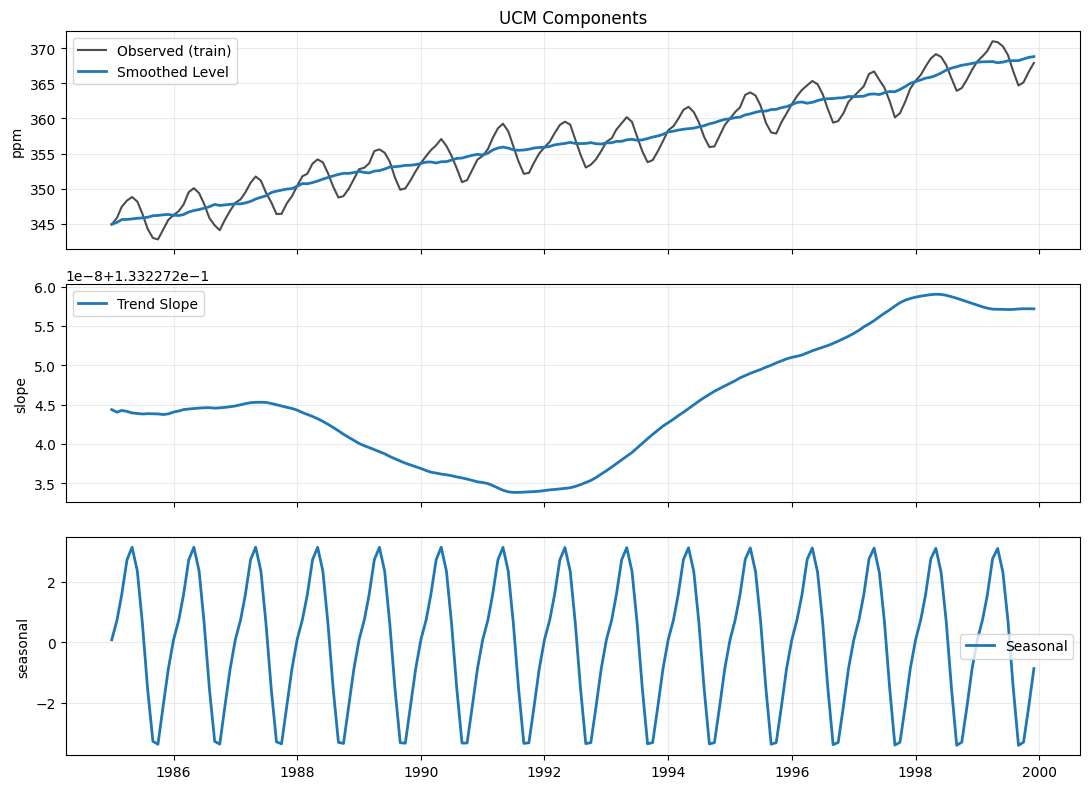

In [40]:
# UCM / Structural TS — Clean, robust plots for probabilistic forecasting
# Dataset: Mauna Loa CO2 (monthly), Train: up to 1999-12, Test: 2000-01..2004-12
# Model: Local linear trend + stochastic seasonality(12)
# Fixes:
#  - Safe component accessor across statsmodels versions (Bunch/Series/ndarray)
#  - Aligned monthly index, no NaNs before fill_between
#  - Clear styling & labels; separate components figure

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents

# ---------- Helpers ----------
def comp_series(res, attr, idx):
    """
    Return a pandas Series for component `attr` from a statsmodels UCM results object `res`,
    robust across versions (Bunch with .smoothed, dict-like, ndarray, or already Series).
    """
    if not hasattr(res, attr):
        return None
    comp = getattr(res, attr)

    # Newer statsmodels: attr might already be a Series/array-like aligned to index
    # Older: attr can be a Bunch with .smoothed; sometimes dict-like {'smoothed': ...}
    if hasattr(comp, "smoothed"):
        comp = comp.smoothed
    elif isinstance(comp, dict) and "smoothed" in comp:
        comp = comp["smoothed"]

    # Convert to Series with the model index
    if isinstance(comp, pd.Series):
        s = comp
        # ensure index equals idx (some versions already do)
        if not s.index.equals(idx):
            s = pd.Series(np.asarray(s), index=idx)
        return s
    else:
        # ndarray or list → Series with idx
        arr = np.asarray(comp).reshape(-1)
        return pd.Series(arr, index=idx)

def coverage_width(y_true, lo, hi):
    inside = (y_true >= lo) & (y_true <= hi)
    return float(inside.mean()), float((hi - lo).mean())

# ---------- Data ----------
co2_w = sm.datasets.co2.load_pandas().data['co2']
# Monthly average; interpolate small gaps so fill_between doesn't break
y = co2_w.resample('MS').mean().interpolate(limit_direction="both")

# Keep a compact but illustrative window
y = y.loc['1985-01-01':'2004-12-01']
y_train = y.loc[:'1999-12-01']
y_test  = y.loc['2000-01-01':]
h = len(y_test)
m = 12

# ---------- Model ----------
ucm = UnobservedComponents(
    y_train,
    level='local linear trend',
    seasonal=m,
    stochastic_seasonal=True
)
res = ucm.fit(disp=False, maxiter=120)

# ---------- Forecast + Intervals ----------
pred = res.get_forecast(steps=h)
mean = pred.predicted_mean
ci80 = pred.conf_int(alpha=0.20)  # 80% PI
ci95 = pred.conf_int(alpha=0.05)  # 95% PI

# Ensure indices have no NaNs and align
assert mean.index.equals(ci80.index) and mean.index.equals(ci95.index)

# ---------- Plot: Forecast with PIs ----------
plt.figure(figsize=(11,5))
(y_train).plot(label="Train", color="black", alpha=0.7)
(y_test).plot(label="Test", color="dimgray", alpha=0.9)
mean.plot(label="UCM forecast", lw=2)

plt.fill_between(ci80.index, ci80.iloc[:,0], ci80.iloc[:,1],
                 alpha=0.25, label="80% PI")
plt.fill_between(ci95.index, ci95.iloc[:,0], ci95.iloc[:,1],
                 alpha=0.12, label="95% PI")

plt.title("UCM (Local Linear Trend + Stochastic Seasonal) — Probabilistic Forecast")
plt.ylabel("CO₂ (ppm)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()

# ---------- Components (Level, Trend slope, Seasonal) ----------
lvl  = comp_series(res, 'level',    y_train.index)
trnd = comp_series(res, 'trend',    y_train.index)  # trend slope; may be None in some specs
seas = comp_series(res, 'seasonal', y_train.index)

rows = 3
fig, ax = plt.subplots(rows, 1, figsize=(11, 8), sharex=True)

# Observed vs smoothed level
ax[0].plot(y_train, color='black', alpha=0.7, label='Observed (train)')
if lvl is not None:
    ax[0].plot(lvl, lw=2, label='Smoothed Level')
ax[0].set_title("UCM Components")
ax[0].set_ylabel("ppm")
ax[0].grid(True, alpha=0.25)
ax[0].legend()

# Trend slope (Δlevel) — prefer explicit trend if present
if trnd is not None:
    ax[1].plot(trnd, lw=2, label='Trend Slope')
else:
    # fallback: first-difference of level as a rough slope proxy
    if lvl is not None:
        ax[1].plot(lvl.diff(), lw=2, label='Δ Level (proxy for slope)')
ax[1].set_ylabel("slope")
ax[1].grid(True, alpha=0.25)
ax[1].legend()

# Seasonal component
if seas is not None:
    ax[2].plot(seas, lw=2, label='Seasonal')
ax[2].set_ylabel("seasonal")
ax[2].grid(True, alpha=0.25)
ax[2].legend()

plt.tight_layout()

# ---------- Calibration check ----------
c80, w80 = coverage_width(y_test, ci80.iloc[:,0], ci80.iloc[:,1])
c95, w95 = coverage_width(y_test, ci95.iloc[:,0], ci95.iloc[:,1])
print(f"80% coverage={c80:.3f}, mean width={w80:.3f}")
print(f"95% coverage={c95:.3f}, mean width={w95:.3f}")

plt.show()



=== ARIMA(2,0,0) coefficient estimates ===
ar.L1    0.626488
ar.L2   -0.264064
dtype: float64

=== ARIMA 95% CI for coefficients ===
              0         1
ar.L1  0.515761  0.737215
ar.L2 -0.372913 -0.155215

=== Bayesian AR(2) 95% credible intervals ===
phi1: 0.520 .. 0.733
phi2: -0.371 .. -0.145
sigma^2: 0.873 .. 1.188


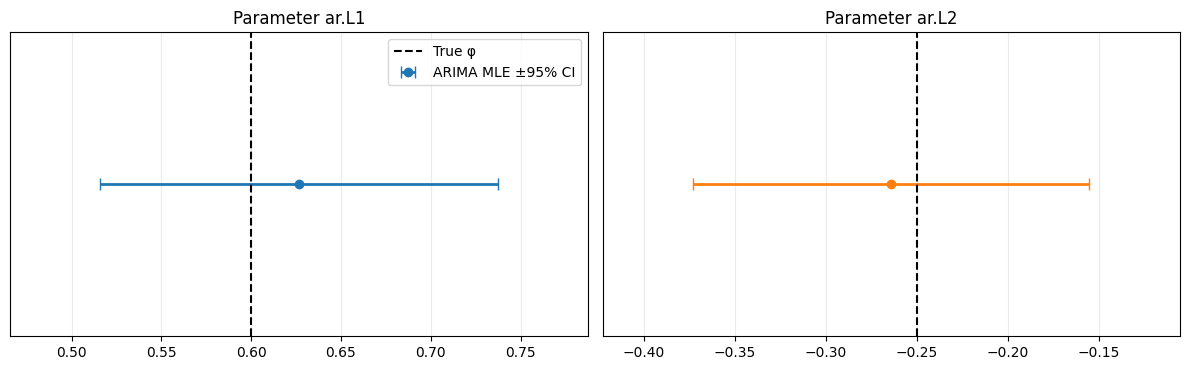

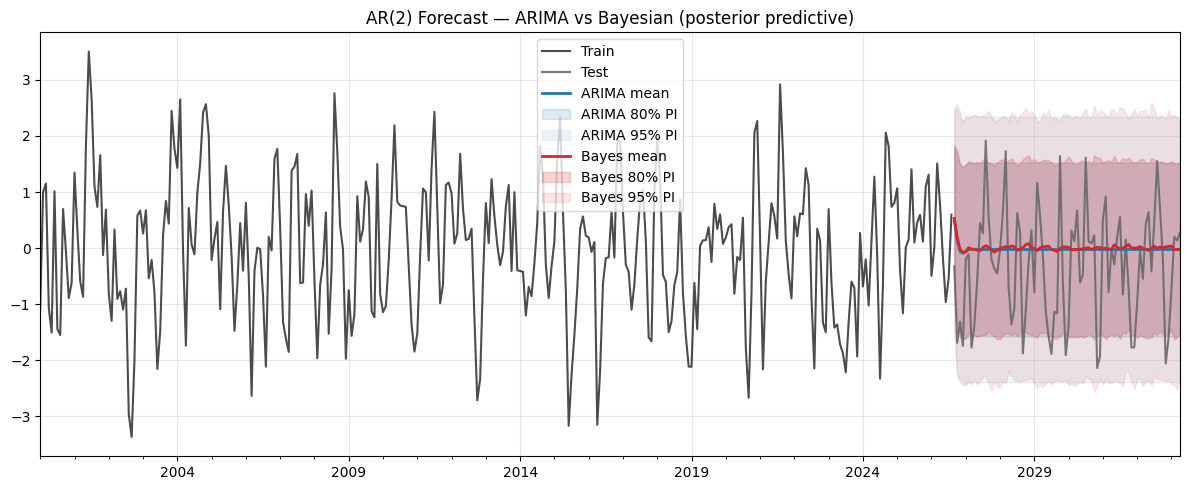

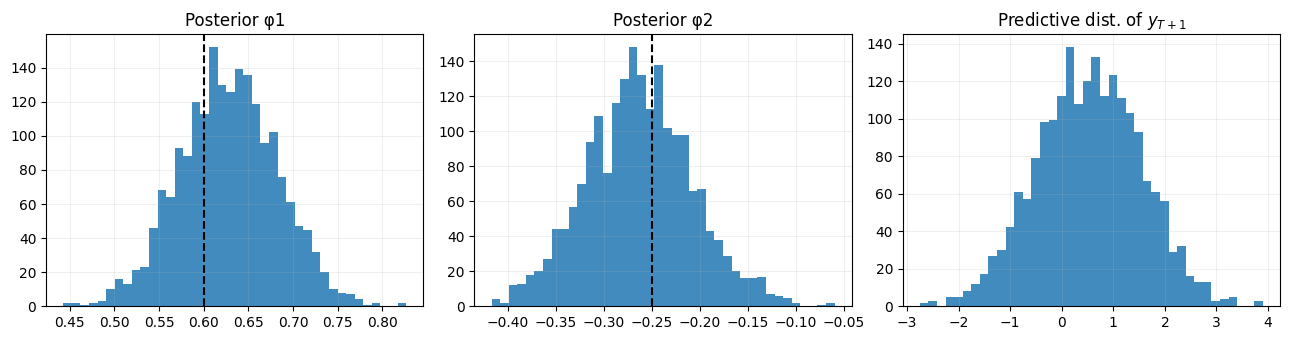


80% coverage on test: ARIMA=0.787 (width=3.091) | Bayesian=0.787 (width=3.094)


In [44]:
# AR(2): Frequentist ARIMA vs Bayesian (Gibbs) with predictive distribution
# Requirements: numpy, pandas, matplotlib, statsmodels

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

np.random.seed(123)

# -----------------------
# 1) Simulate AR(2) data
# -----------------------
n = 400
phi_true = np.array([0.6, -0.25])  # φ1, φ2 (stationary)
sigma_true = 1.0

y = np.zeros(n)
y[:2] = np.random.normal(0, sigma_true, size=2)
for t in range(2, n):
    y[t] = phi_true[0]*y[t-1] + phi_true[1]*y[t-2] + np.random.normal(0, sigma_true)

idx = pd.date_range("2000-01-01", periods=n, freq="M")
y = pd.Series(y, index=idx)

# Train/Test
train_frac = 0.8
T_train = int(len(y)*train_frac)
y_train = y.iloc[:T_train]
y_test  = y.iloc[T_train:]
h = len(y_test)

# ---------------------------------
# 2) Frequentist: ARIMA(2,0,0) fit
# ---------------------------------
fit = ARIMA(y_train, order=(2,0,0)).fit()

# Coeff estimates and 95% CIs
ci_mle = fit.conf_int()
phi_mle = fit.params[["ar.L1", "ar.L2"]]
print("\n=== ARIMA(2,0,0) coefficient estimates ===")
print(phi_mle)
print("\n=== ARIMA 95% CI for coefficients ===")
print(ci_mle.loc[["ar.L1","ar.L2"]])

# Forecast with 80% & 95% PIs
fc = fit.get_forecast(steps=h)
mean_fc = fc.predicted_mean
ci80_fc = fc.conf_int(alpha=0.20).astype(float)
ci95_fc = fc.conf_int(alpha=0.05).astype(float)

# -----------------------------------------------
# 3) Bayesian AR(2): Normal–Inverse-Gamma (Gibbs)
# -----------------------------------------------
# Regression form on train data (drop first 2 rows for lags)
Y = y_train.values[2:]                          # y_t
X = np.column_stack([y_train.values[1:-1],      # y_{t-1}
                     y_train.values[0:-2]])     # y_{t-2}
n_obs, k = X.shape

# Weakly-informative priors
V0 = np.eye(k) * (10.0**2)   # prior covariance scale for beta
b0 = np.zeros(k)             # prior mean for beta
a0 = 2.0                     # Inv-Gamma prior shape
b0_scale = 1.0               # Inv-Gamma prior scale

XtX = X.T @ X
XtY = X.T @ Y
V0_inv = np.linalg.inv(V0)

def sample_sigma2(Y, X, beta, a0, b0):
    resid = Y - X @ beta
    an = a0 + len(Y)/2
    bn = b0 + 0.5 * resid @ resid
    return 1.0 / np.random.gamma(an, 1.0/bn)

def sample_beta(Y, X, sigma2, b0, V0_inv):
    Vn_inv = XtX + V0_inv
    Vn = np.linalg.inv(Vn_inv)
    bn = Vn @ (XtY + V0_inv @ b0)
    return np.random.multivariate_normal(bn, sigma2 * Vn)

# Initialize from OLS
beta = np.linalg.solve(XtX + 1e-8*np.eye(k), XtY)
sigma2 = np.var(Y - X @ beta)

n_iter, burn = 4000, 2000
draws_beta = np.zeros((n_iter-burn, k))
draws_sigma2 = np.zeros(n_iter-burn)

for it in range(n_iter):
    sigma2 = sample_sigma2(Y, X, beta, a0, b0_scale)
    beta = sample_beta(Y, X, sigma2, b0, V0_inv)
    if it >= burn:
        draws_beta[it-burn,:] = beta
        draws_sigma2[it-burn] = sigma2

phi1_post = draws_beta[:,0]
phi2_post = draws_beta[:,1]

def cred_int(x, level=0.95):
    a = (1-level)/2
    return np.quantile(x, [a, 1-a])

ci_phi1 = cred_int(phi1_post, 0.95)
ci_phi2 = cred_int(phi2_post, 0.95)
ci_sig2 = cred_int(draws_sigma2, 0.95)

print("\n=== Bayesian AR(2) 95% credible intervals ===")
print(f"phi1: {ci_phi1[0]:.3f} .. {ci_phi1[1]:.3f}")
print(f"phi2: {ci_phi2[0]:.3f} .. {ci_phi2[1]:.3f}")
print(f"sigma^2: {ci_sig2[0]:.3f} .. {ci_sig2[1]:.3f}")

# -----------------------------------------------
# 4) Posterior predictive distribution (recursive)
# -----------------------------------------------
B = draws_beta.shape[0]
paths = np.zeros((B, h))
last2 = y_train.values[-2:].copy()

for b in range(B):
    b1, b2 = draws_beta[b]
    s2 = draws_sigma2[b]
    y_future = np.zeros(h)
    lag2 = last2.copy()
    for t in range(h):
        mu = b1*lag2[1] + b2*lag2[0]
        y_future[t] = np.random.normal(mu, np.sqrt(s2))
        lag2[0], lag2[1] = lag2[1], y_future[t]
    paths[b,:] = y_future

# Summaries
pred_mean_bayes = paths.mean(axis=0)
pred_lo80_bayes = np.quantile(paths, 0.10, axis=0)
pred_hi80_bayes = np.quantile(paths, 0.90, axis=0)
pred_lo95_bayes = np.quantile(paths, 0.025, axis=0)
pred_hi95_bayes = np.quantile(paths, 0.975, axis=0)

pred_mean_bayes_s = pd.Series(pred_mean_bayes, index=y_test.index)
lo80_bayes_s = pd.Series(pred_lo80_bayes, index=y_test.index)
hi80_bayes_s = pd.Series(pred_hi80_bayes, index=y_test.index)
lo95_bayes_s = pd.Series(pred_lo95_bayes, index=y_test.index)
hi95_bayes_s = pd.Series(pred_hi95_bayes, index=y_test.index)

# -----------------------
# 5) Plots
# -----------------------

# (A) Parameter estimates: ARIMA MLE ±95% CI
# --- DROP-IN REPLACEMENT for the "Parameter estimates" plot block ---

# Gather numbers
names = ["ar.L1","ar.L2"]
true_vals = [phi_true[0], phi_true[1]]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.8), sharey=True)

for j, (name, true_val) in enumerate(zip(names, true_vals)):
    ax = axes[j]

    est = float(phi_mle[name])
    lo, hi = ci_mle.loc[name].astype(float).values

    # horizontal error bar at y=0
    xerr = np.array([[est - lo], [hi - est]])  # left, right
    ax.errorbar(
        x=est, y=0, xerr=xerr, fmt="o", lw=2, ms=6, capsize=4, color=f"C{j}",
        label="ARIMA MLE ±95% CI"
    )

    # true coefficient (vertical line)
    ax.axvline(true_val, color="black", ls="--", lw=1.5, label="True φ" if j == 0 else None)

    # formatting
    pad = max(0.05, 0.2 * max(abs(hi-est), abs(est-lo)))
    ax.set_xlim(min(lo, true_val) - pad, max(hi, true_val) + pad)
    ax.set_yticks([])
    ax.set_title(f"Parameter {name}")
    ax.grid(alpha=0.25)
    if j == 0:
        ax.legend(loc="best")

plt.tight_layout()
plt.show()


# (B) Forecast: ARIMA vs Bayesian (80% & 95% bands)
plt.figure(figsize=(12,5))
y_train.plot(label="Train", color="black", alpha=0.7)
y_test.plot(label="Test", color="dimgray", alpha=0.9)

mean_fc.plot(label="ARIMA mean", lw=2, color="C0")
plt.fill_between(ci80_fc.index, ci80_fc.iloc[:,0].values, ci80_fc.iloc[:,1].values,
                 alpha=0.15, label="ARIMA 80% PI", color="C0")
plt.fill_between(ci95_fc.index, ci95_fc.iloc[:,0].values, ci95_fc.iloc[:,1].values,
                 alpha=0.08, label="ARIMA 95% PI", color="C0")

pred_mean_bayes_s.plot(label="Bayes mean", lw=2, color="C3")
plt.fill_between(lo80_bayes_s.index, lo80_bayes_s.values, hi80_bayes_s.values,
                 alpha=0.20, label="Bayes 80% PI", color="C3")
plt.fill_between(lo95_bayes_s.index, lo95_bayes_s.values, hi95_bayes_s.values,
                 alpha=0.10, label="Bayes 95% PI", color="C3")

plt.title("AR(2) Forecast — ARIMA vs Bayesian (posterior predictive)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()

# (C) Posterior of φ1, φ2 and predictive distribution for y_{T+1}
fig, ax = plt.subplots(1,3, figsize=(13,3.5))
ax[0].hist(phi1_post, bins=40, alpha=0.85); ax[0].axvline(phi_true[0], color="black", ls="--")
ax[0].set_title("Posterior φ1"); ax[0].grid(True, alpha=0.2)
ax[1].hist(phi2_post, bins=40, alpha=0.85); ax[1].axvline(phi_true[1], color="black", ls="--")
ax[1].set_title("Posterior φ2"); ax[1].grid(True, alpha=0.2)
ax[2].hist(paths[:,0], bins=40, alpha=0.85)
ax[2].set_title("Predictive dist. of $y_{T+1}$"); ax[2].grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# -----------------------
# 6) Quick 80% coverage check on test
# -----------------------
def cov_width(y_true, lo, hi):
    inside = (y_true>=lo)&(y_true<=hi)
    return float(inside.mean()), float((hi-lo).mean())

cov80_arima, w80_arima = cov_width(y_test, ci80_fc.iloc[:,0], ci80_fc.iloc[:,1])
cov80_bayes, w80_bayes = cov_width(y_test, lo80_bayes_s, hi80_bayes_s)
print(f"\n80% coverage on test: ARIMA={cov80_arima:.3f} (width={w80_arima:.3f}) | "
      f"Bayesian={cov80_bayes:.3f} (width={w80_bayes:.3f})")


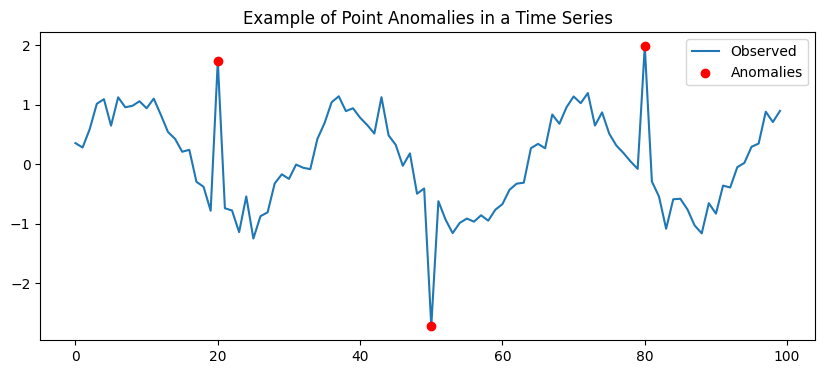

In [47]:
import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)
t = np.arange(100)
y = np.sin(t/5) + np.random.normal(0, 0.2, 100)
y[[20, 50, 80]] += [3, -2, 2.5]  # Inject anomalies

plt.figure(figsize=(10,4))
plt.plot(t, y, label='Observed')
plt.scatter([20,50,80], y[[20,50,80]], color='red', label='Anomalies', zorder=5)
plt.title('Example of Point Anomalies in a Time Series')
plt.legend(); plt.show()


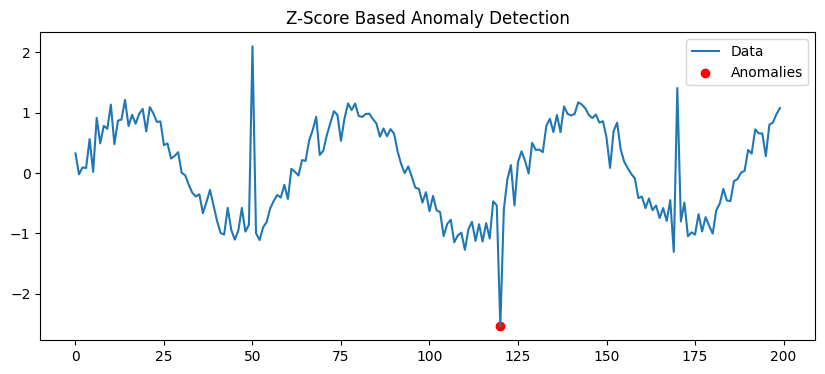

In [48]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

np.random.seed(1)
t = np.arange(200)
y = np.sin(t/10) + np.random.normal(0, 0.2, 200)
y[[50,120,170]] += [3, -2, 2.5]

mean, std = np.mean(y), np.std(y)
z = (y - mean) / std
anomalies = np.where(np.abs(z) > 3)[0]

plt.figure(figsize=(10,4))
plt.plot(t, y, label='Data')
plt.scatter(t[anomalies], y[anomalies], color='red', label='Anomalies')
plt.title('Z-Score Based Anomaly Detection')
plt.legend(); plt.show()


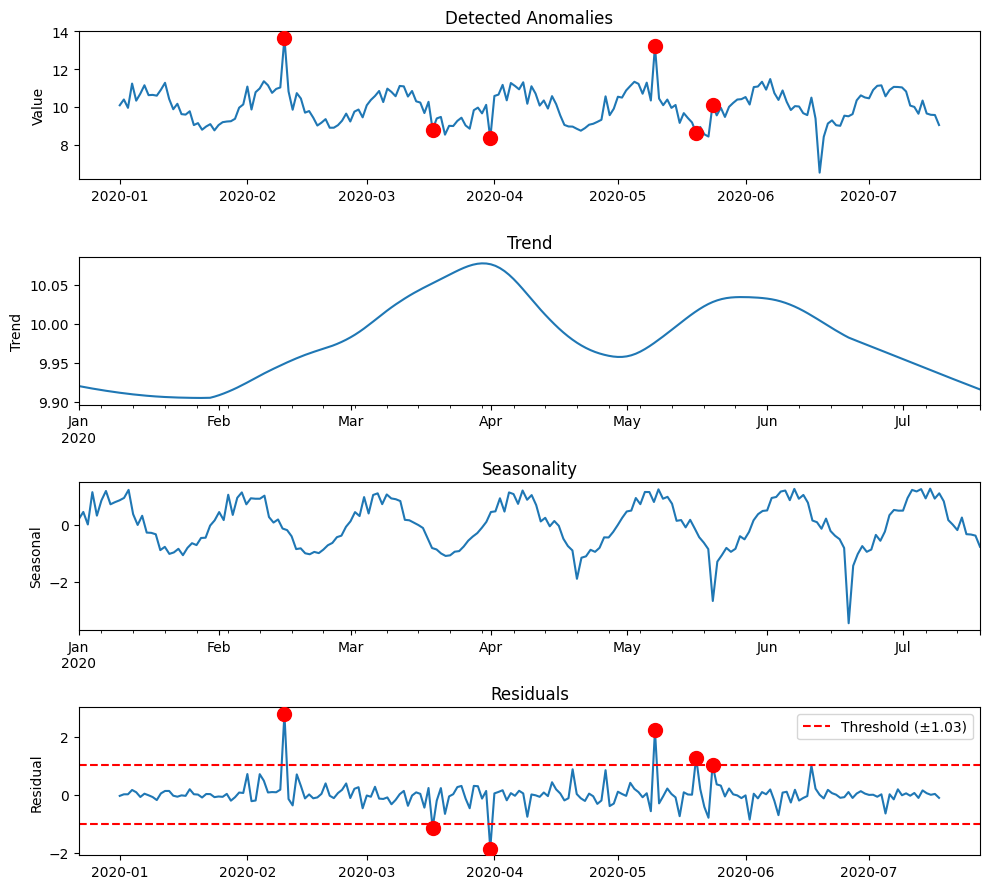

Detected 6 anomalies at indices: [Timestamp('2020-02-10 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-20 00:00:00'), Timestamp('2020-05-24 00:00:00')]
Expected anomalies at indices: [Timestamp('2020-02-10 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-06-19 00:00:00')]


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

np.random.seed(2)
t = pd.date_range('2020-01-01', periods=200, freq='D')
y = 10 + np.sin(2*np.pi*t.dayofyear.values/30) + np.random.normal(0, 0.3, 200)
y[[40, 90, 130, 170]] += [3, -2, 2.5, -3]  # anomalies
series = pd.Series(y, index=t)

# Use robust STL to handle outliers better
stl = STL(series, period=30, robust=True)
res = stl.fit()

residual = res.resid
threshold = 2.5 * np.std(residual)  # Lowered threshold for better detection
anomalies = series[np.abs(residual) > threshold]

fig, ax = plt.subplots(4, 1, figsize=(10, 9))
ax[0].plot(series)
ax[0].scatter(anomalies.index, anomalies, color='red', s=100, zorder=5)
ax[0].set_title("Detected Anomalies")
ax[0].set_ylabel("Value")

res.trend.plot(ax=ax[1])
ax[1].set_title("Trend")
ax[1].set_ylabel("Trend")

res.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonality")
ax[2].set_ylabel("Seasonal")

ax[3].plot(residual)
ax[3].axhline(y=threshold, color='r', linestyle='--', label=f'Threshold (±{threshold:.2f})')
ax[3].axhline(y=-threshold, color='r', linestyle='--')
ax[3].scatter(anomalies.index, residual[anomalies.index], color='red', s=100, zorder=5)
ax[3].set_title("Residuals")
ax[3].set_ylabel("Residual")
ax[3].legend()

plt.tight_layout()
plt.show()

print(f"Detected {len(anomalies)} anomalies at indices: {anomalies.index.tolist()}")
print(f"Expected anomalies at indices: {t[[40, 90, 130, 170]].tolist()}")

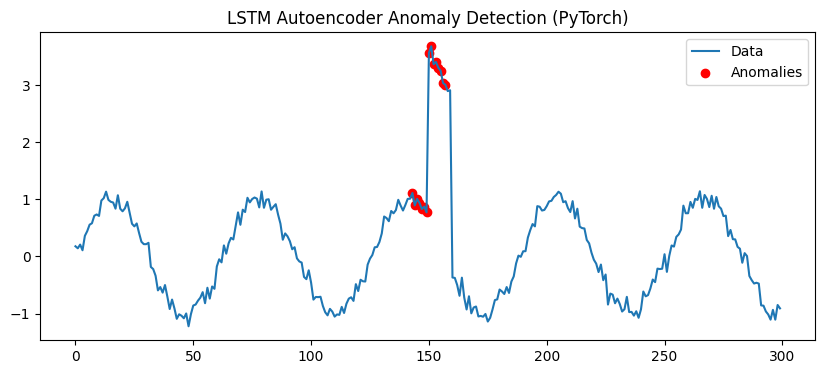

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# --- Simulated data ---
np.random.seed(3)
t = np.arange(300)
y = np.sin(t/10) + np.random.normal(0, 0.1, 300)
y[150:160] += 3  # anomaly segment
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1))

# --- Prepare sequences ---
seq_len = 10
X = np.array([y_scaled[i:i+seq_len] for i in range(len(y_scaled)-seq_len)])
X_tensor = torch.FloatTensor(X)

# --- LSTM Autoencoder ---
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, input_dim=1, hidden_dim=16):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Repeat hidden state for decoder
        hidden_repeated = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)
        
        # Decoder
        decoder_out, _ = self.decoder(hidden_repeated)
        
        # Output
        out = self.output_layer(decoder_out)
        return out

model = LSTMAutoencoder(seq_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training ---
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()

# --- Reconstruction error ---
model.eval()
with torch.no_grad():
    X_pred = model(X_tensor).numpy()

mse = np.mean(np.power(X - X_pred, 2), axis=(1,2))
threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]

plt.figure(figsize=(10,4))
plt.plot(y, label='Data')
plt.scatter(anomalies, y[anomalies], color='red', label='Anomalies')
plt.title('LSTM Autoencoder Anomaly Detection (PyTorch)')
plt.legend()
plt.show()


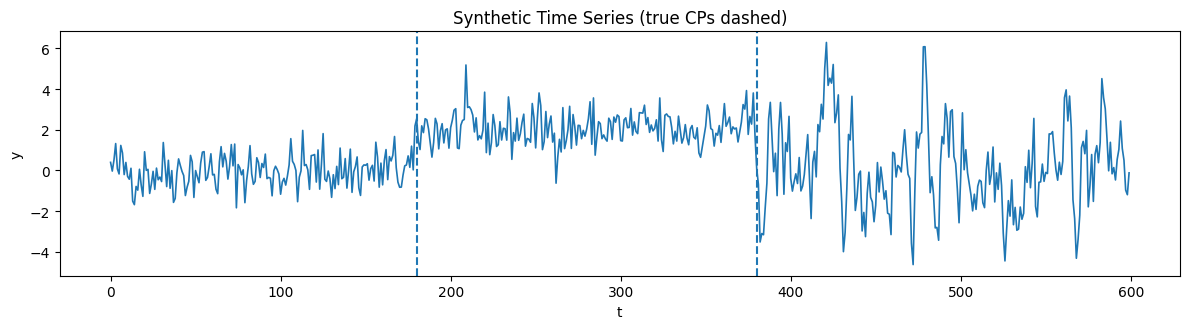

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- synthetic 3-regime series ---
n = 600
phi1, mu1, s1 = 0.2, 0.0, 0.8           # Regime 1
phi2, mu2, s2 = 0.2, 2.0, 0.8           # Regime 2 (mean shift up)
phi3, mu3, s3 = 0.7, 0.5, 1.5           # Regime 3 (higher var, sticky AR)

cp1, cp2 = 180, 380                     # true change-points

y = np.zeros(n)
for i in range(n):
    if i < cp1:
        phi, mu, s = phi1, mu1, s1
    elif i < cp2:
        phi, mu, s = phi2, mu2, s2
    else:
        phi, mu, s = phi3, mu3, s3
    e = np.random.normal(0, s)
    y[i] = (mu if i == 0 else mu + phi*(y[i-1]-mu)) + e

# quick look
plt.figure(figsize=(12,3.4))
plt.plot(y, lw=1.2)
plt.axvline(cp1, ls="--")
plt.axvline(cp2, ls="--")
plt.title("Synthetic Time Series (true CPs dashed)")
plt.xlabel("t"); plt.ylabel("y")
plt.tight_layout(); plt.show()


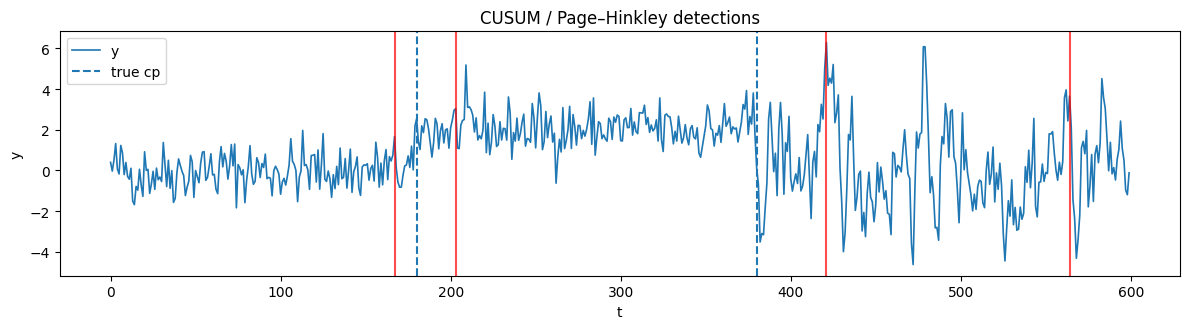

Page–Hinkley detected CPs (first 10): [167, 203, 421, 564]


In [3]:
def page_hinkley(x, delta=0.05, lambda_=8.0, alpha=0.995):
    """
    Page-Hinkley mean-shift detector.
    delta: ignore tiny fluctuations
    lambda_: threshold (bigger => fewer detections)
    alpha: forgetting factor for running stats
    """
    x = np.asarray(x)
    mean = 0.0
    cum = 0.0
    m_min = 0.0
    cps = []
    for i, xi in enumerate(x):
        mean = alpha*mean + (1-alpha)*xi
        cum = alpha*cum + (xi - mean - delta)
        m_min = min(m_min, cum)
        if (cum - m_min) > lambda_:
            cps.append(i)
            # reset after alarm
            cum, m_min = 0.0, 0.0
            mean = xi
    return cps

ph_cps = page_hinkley(y, delta=0.05, lambda_=8.0, alpha=0.995)

plt.figure(figsize=(12,3.4))
plt.plot(y, lw=1.2, label="y")
plt.axvline(cp1, ls="--", label="true cp")
plt.axvline(cp2, ls="--")
for i in ph_cps:
    plt.axvline(i, color="r", lw=1.5, alpha=0.7)
plt.title("CUSUM / Page–Hinkley detections")
plt.xlabel("t"); plt.ylabel("y")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Page–Hinkley detected CPs (first 10):", ph_cps[:10])


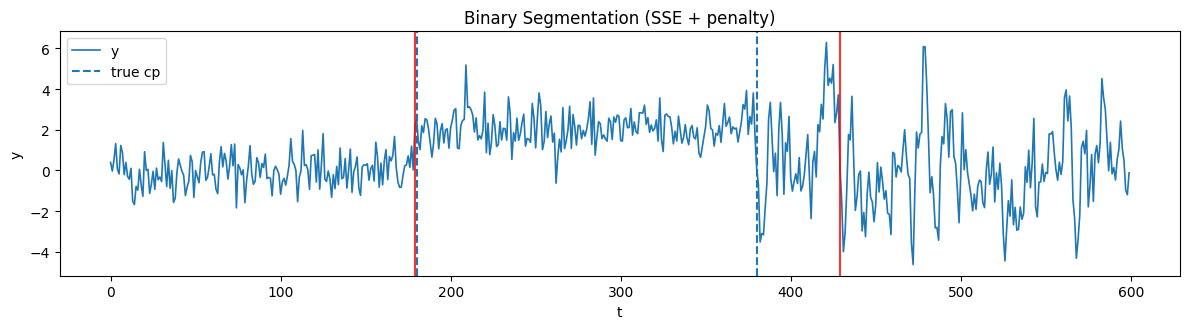

Binary Segmentation CPs: [179, 429]


In [5]:
def segment_cost(y, s, e):
    seg = y[s:e]
    if len(seg) == 0:
        return 0.0
    m = seg.mean()
    return np.sum((seg - m)**2)

def best_split(y, s, e, min_size=30):
    base = segment_cost(y, s, e)
    best_gain, best_k = 0.0, None
    for k in range(s+min_size, e-min_size):
        left  = segment_cost(y, s, k)
        right = segment_cost(y, k, e)
        gain = base - (left + right)
        if gain > best_gain:
            best_gain, best_k = gain, k
    return best_k, best_gain

def binary_segmentation(y, penalty=120.0, min_size=25, max_splits=8):
    n = len(y)
    segs = [(0, n)]
    cps = []
    improved = True
    while improved and len(cps) < max_splits:
        improved = False
        best = (None, -np.inf, None)  # (k, score, seg_idx)
        for idx, (s, e) in enumerate(segs):
            if e - s < 2*min_size:
                continue
            k, gain = best_split(y, s, e, min_size)
            score = gain - penalty
            if (k is not None) and (score > best[1]):
                best = (k, score, idx)
        if best[0] is not None and best[1] > 0:
            k, _, j = best
            s, e = segs.pop(j)
            segs.extend([(s, k), (k, e)])
            segs.sort(key=lambda x: x[0])
            cps.append(k)
            improved = True
    return sorted(cps)

bs_cps = binary_segmentation(y, penalty=120.0, min_size=25, max_splits=8)

plt.figure(figsize=(12,3.4))
plt.plot(y, lw=1.2, label="y")
plt.axvline(cp1, ls="--", label="true cp")
plt.axvline(cp2, ls="--")
for i in bs_cps:
    plt.axvline(i, lw=1.5, alpha=0.8, color="r")
plt.title("Binary Segmentation (SSE + penalty)")
plt.xlabel("t"); plt.ylabel("y")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Binary Segmentation CPs:", bs_cps)


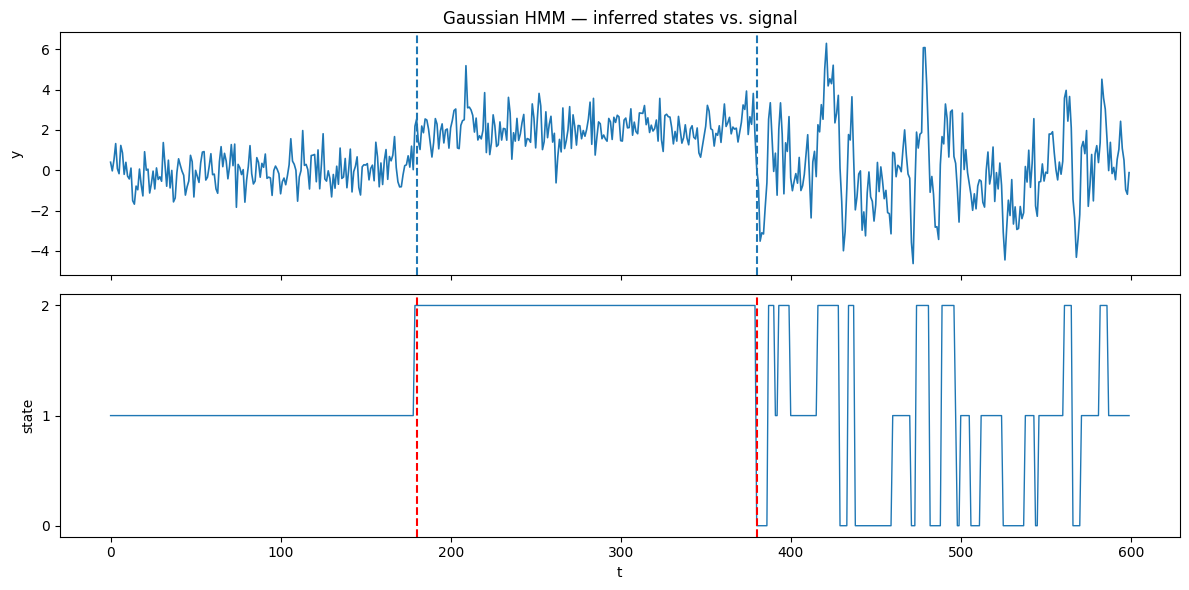

HMM params:
pi: [0. 1. 0.]
A:
 [[0.848 0.078 0.075]
 [0.016 0.963 0.021]
 [0.027 0.016 0.957]]
mu: [-1.803  0.003  2.179]
var: [1.549 0.716 1.03 ]


In [11]:
from dataclasses import dataclass

@dataclass
class HMMParams:
    pi:  np.ndarray   # initial probs (K,)
    A:   np.ndarray   # transition matrix (K,K)
    mu:  np.ndarray   # means (K,)
    var: np.ndarray   # variances (K,)

def gaussian_likelihood(y, mu, var):
    K, T = len(mu), len(y)
    B = np.empty((T, K))
    for k in range(K):
        v = var[k]
        coef = 1.0 / np.sqrt(2*np.pi*v)
        B[:, k] = coef * np.exp(-0.5 * (y - mu[k])**2 / v)
    return B

def forward_backward(y, params: HMMParams):
    T, K = len(y), len(params.mu)
    B = gaussian_likelihood(y, params.mu, params.var)

    # forward with scaling
    alpha = np.zeros((T, K))
    c = np.zeros(T)
    alpha[0] = params.pi * B[0]
    c[0] = alpha[0].sum()
    alpha[0] /= (c[0] + 1e-15)
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ params.A) * B[t]
        c[t] = alpha[t].sum()
        alpha[t] /= (c[t] + 1e-15)

    # backward with normalization
    beta = np.zeros((T, K))
    beta[-1] = 1.0
    for t in range(T-2, -1, -1):
        beta[t] = params.A @ (B[t+1] * beta[t+1])
        beta[t] /= (beta[t].sum() + 1e-15)

    gamma = alpha * beta
    gamma /= (gamma.sum(axis=1, keepdims=True) + 1e-15)

    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        num = (alpha[t][:,None] * params.A) * (B[t+1] * beta[t+1])[None,:]
        den = num.sum()
        xi[t] = num / (den + 1e-15)

    return gamma, xi, c

def m_step(y, gamma, xi):
    T, K = gamma.shape
    pi_new = gamma[0] / (gamma[0].sum() + 1e-15)
    A_new = xi.sum(axis=0)
    A_new = A_new / (A_new.sum(axis=1, keepdims=True) + 1e-15)
    mu_new  = (gamma * y[:,None]).sum(axis=0) / (gamma.sum(axis=0) + 1e-15)
    var_new = (gamma * (y[:,None]-mu_new[None,:])**2).sum(axis=0) / (gamma.sum(axis=0) + 1e-15)
    var_new = np.clip(var_new, 1e-6, None)
    return HMMParams(pi_new, A_new, mu_new, var_new)

def baum_welch(y, K=3, max_iter=100, tol=1e-4):
    y = np.asarray(y)
    pi  = np.ones(K) / K
    A   = np.ones((K,K)); A /= A.sum(axis=1, keepdims=True)
    mu  = np.linspace(y.min(), y.max(), K)
    var = np.full(K, y.var())
    params = HMMParams(pi, A, mu, var)

    prev_ll = -np.inf
    for it in range(max_iter):
        gamma, xi, c = forward_backward(y, params)
        ll = np.sum(np.log(c + 1e-15))  # scaled log-likelihood
        params = m_step(y, gamma, xi)
        if it > 0 and abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    gamma, xi, c = forward_backward(y, params)
    states = gamma.argmax(axis=1)
    return params, states, gamma

params, states, _ = baum_welch(y, K=3, max_iter=100, tol=1e-4)

# Plot regimes
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
ax[0].plot(y, lw=1.2)
ax[0].axvline(cp1, ls="--"); ax[0].axvline(cp2, ls="--")
ax[0].set_title("Gaussian HMM — inferred states vs. signal")
ax[0].set_ylabel("y")

ax[1].plot(states, lw=1)
ax[1].set_yticks([0,1,2]); ax[1].set_ylabel("state"); ax[1].set_xlabel("t")
ax[1].axvline(cp1, ls="--", color="r"); ax[1].axvline(cp2, ls="--", color="r")
plt.tight_layout(); plt.show()

print("HMM params:")
print("pi:", np.round(params.pi, 3))
print("A:\n", np.round(params.A, 3))
print("mu:", np.round(params.mu, 3))
print("var:", np.round(params.var, 3))


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Age: 20..80 (inclusive), Period: 2000..2020 (inclusive)
ages = np.arange(20, 81)        # 61 ages
periods = np.arange(2000, 2021) # 21 periods
grid = pd.MultiIndex.from_product([ages, periods], names=['age','period']).to_frame(index=False)
grid['cohort'] = grid['period'] - grid['age']

# Exposures (person-years) - vary a bit with age to be realistic
grid['exposure'] = 1000 * (1 - 0.004*(grid['age']-20))  # higher at younger ages, just for demo
grid['exposure'] = grid['exposure'].clip(lower=200)

# True smooth effects (centered) to generate data
# Age effect: convex (e.g., risk rises with age)
age_vals = grid['age'].unique()
age_eff_true = 0.015*(age_vals-50) + 0.0007*(age_vals-50)**2
age_eff_true -= age_eff_true.mean()

# Period effect: gentle wavy trend (e.g., tech/medical progress)
per_vals = grid['period'].unique()
per_eff_true = 0.12*np.sin((per_vals-2000)/4.0) - 0.004*(per_vals-2000)
per_eff_true -= per_eff_true.mean()

# Cohort effect: generational bump (e.g., smoking generation)
coh_vals = grid['cohort'].unique()
coh_eff_true = 0.2*np.exp(-((coh_vals-1960)/10)**2) - 0.03*((coh_vals-1960)/10)
coh_eff_true -= coh_eff_true.mean()

# Map effects back to rows
age_map = dict(zip(age_vals, age_eff_true))
per_map = dict(zip(per_vals, per_eff_true))
coh_map = dict(zip(coh_vals, coh_eff_true))

grid['eta'] = grid['age'].map(age_map) + grid['period'].map(per_map) + grid['cohort'].map(coh_map) + np.log(grid['exposure'])
mu = np.exp(grid['eta'])  # mean counts

# Simulate Poisson counts
rng = np.random.default_rng(123)
grid['count'] = rng.poisson(mu)

grid.head(5)


,age,period,cohort,exposure,eta,count
0,20,2000,1980,1000.0,6.797106,911
1,20,2001,1981,1000.0,6.818562,888
2,20,2002,1982,1000.0,6.838555,901
3,20,2003,1983,1000.0,6.855248,1003
4,20,2004,1984,1000.0,6.867049,992


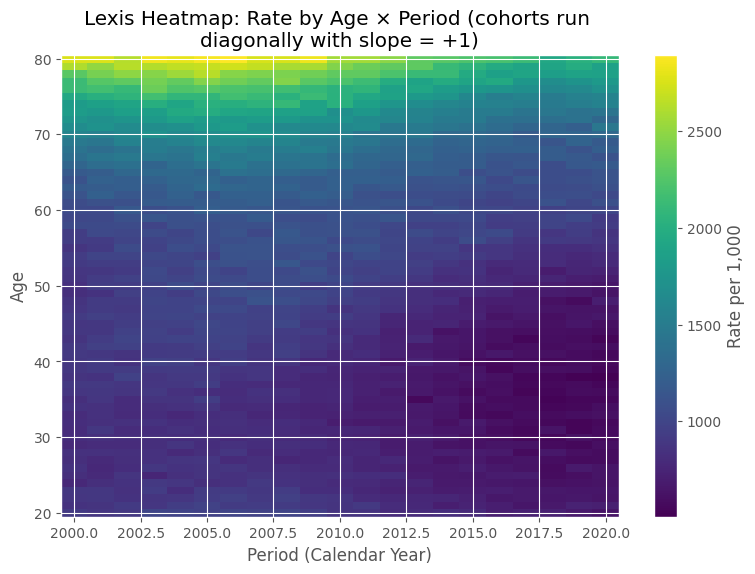

In [17]:
# Event rate per 1,000 exposure
grid['rate_per_1000'] = 1000 * grid['count'] / grid['exposure']

rate_mat = grid.pivot(index='age', columns='period', values='rate_per_1000').sort_index(ascending=True)

plt.figure(figsize=(9,6))
plt.imshow(rate_mat.values, aspect='auto', origin='lower',
           extent=[rate_mat.columns.min()-0.5, rate_mat.columns.max()+0.5,
                   rate_mat.index.min()-0.5, rate_mat.index.max()+0.5])
plt.colorbar(label='Rate per 1,000')
plt.xlabel('Period (Calendar Year)')
plt.ylabel('Age')
plt.title('Lexis Heatmap: Rate by Age × Period (cohorts run \ndiagonally with slope = +1)')
plt.show()


In [51]:
# AP Model with linear and monotonicity assumtions 
import statsmodels.api as sm
import numpy as np

# Design matrix: Age and Period as continuous variables
X_ap_cont = sm.add_constant(grid[['age', 'period']])
y = grid['count'].values
offset = np.log(grid['exposure'].values)

model_ap_cont = sm.GLM(y, X_ap_cont, family=sm.families.Poisson(), offset=offset)
res_ap_cont = model_ap_cont.fit()
print(res_ap_cont.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1281
Model:                            GLM   Df Residuals:                     1278
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23343.
Date:                Sun, 19 Oct 2025   Deviance:                       35634.
Time:                        10:11:44   Pearson chi2:                 3.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0656      0.304    108.690      0.0

In [40]:
import statsmodels.api as sm
from patsy import dmatrix

# Design matrix: Age and Period as categorical (can swap for splines if you prefer)
X_ap = dmatrix("C(age) + C(period)", grid, return_type='dataframe')
y = grid['count'].values
offset = np.log(grid['exposure'].values)

model_ap = sm.GLM(y, X_ap, family=sm.families.Poisson(), offset=offset)
res_ap = model_ap.fit()
print(res_ap.summary().as_text()[:2100]+ '        ...       ...         ...')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1281
Model:                            GLM   Df Residuals:                     1200
Model Family:                 Poisson   Df Model:                           80
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7197.9
Date:                Sun, 19 Oct 2025   Deviance:                       3344.6
Time:                        09:52:32   Pearson chi2:                 3.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1042      0.00

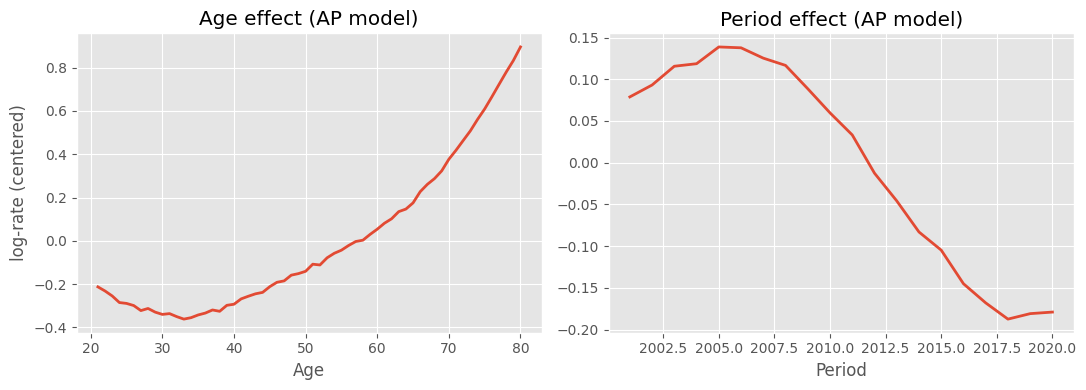

In [42]:
# Recover effects (centered to mean zero for plotting)
design_cols = X_ap.columns
age_cols = [c for c in design_cols if c.startswith('C(age)')]
per_cols = [c for c in design_cols if c.startswith('C(period)')]

# Extract numeric values, handling 'T.' prefix
age_indices = []
for c in age_cols:
    # Extract the part between brackets: 'C(age)[T.21]' -> 'T.21'
    val = c.split('[')[-1][:-1]
    # Remove 'T.' prefix if present: 'T.21' -> '21'
    if val.startswith('T.'):
        val = val[2:]
    age_indices.append(int(val))

per_indices = []
for c in per_cols:
    val = c.split('[')[-1][:-1]
    if val.startswith('T.'):
        val = val[2:]
    per_indices.append(int(val))

age_eff_hat_ap = pd.Series(res_ap.params[age_cols].values, 
                           index=age_indices).sort_index()
per_eff_hat_ap = pd.Series(res_ap.params[per_cols].values, 
                           index=per_indices).sort_index()

age_eff_hat_ap -= age_eff_hat_ap.mean()
per_eff_hat_ap -= per_eff_hat_ap.mean()

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(age_eff_hat_ap.index, age_eff_hat_ap.values, label='Estimated Age (AP)', lw=2)
ax[0].set_title('Age effect (AP model)'); ax[0].set_xlabel('Age'); ax[0].set_ylabel('log-rate (centered)')
ax[0].grid(True)
ax[1].plot(per_eff_hat_ap.index, per_eff_hat_ap.values, label='Estimated Period (AP)', lw=2)
ax[1].set_title('Period effect (AP model)'); ax[1].set_xlabel('Period')
ax[1].grid(True)
plt.tight_layout(); plt.show()

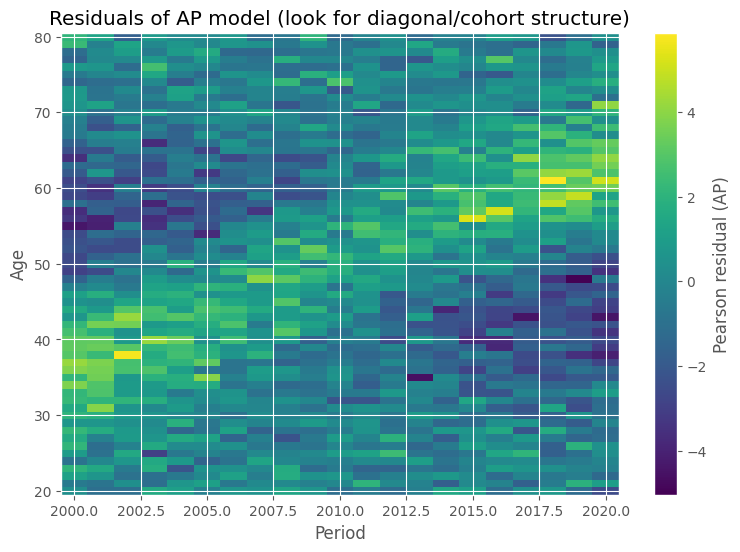

In [43]:
grid['mu_ap'] = res_ap.predict(X_ap, offset=offset)
grid['pearson_resid_ap'] = (grid['count'] - grid['mu_ap']) / np.sqrt(np.maximum(grid['mu_ap'],1e-9))

resid_mat = grid.pivot(index='age', columns='period', values='pearson_resid_ap').sort_index()
plt.figure(figsize=(9,6))
plt.imshow(resid_mat.values, aspect='auto', origin='lower',
           extent=[resid_mat.columns.min()-0.5, resid_mat.columns.max()+0.5,
                   resid_mat.index.min()-0.5, resid_mat.index.max()+0.5])
plt.colorbar(label='Pearson residual (AP)')
plt.xlabel('Period'); plt.ylabel('Age')
plt.title('Residuals of AP model (look for diagonal/cohort structure)')
plt.show()


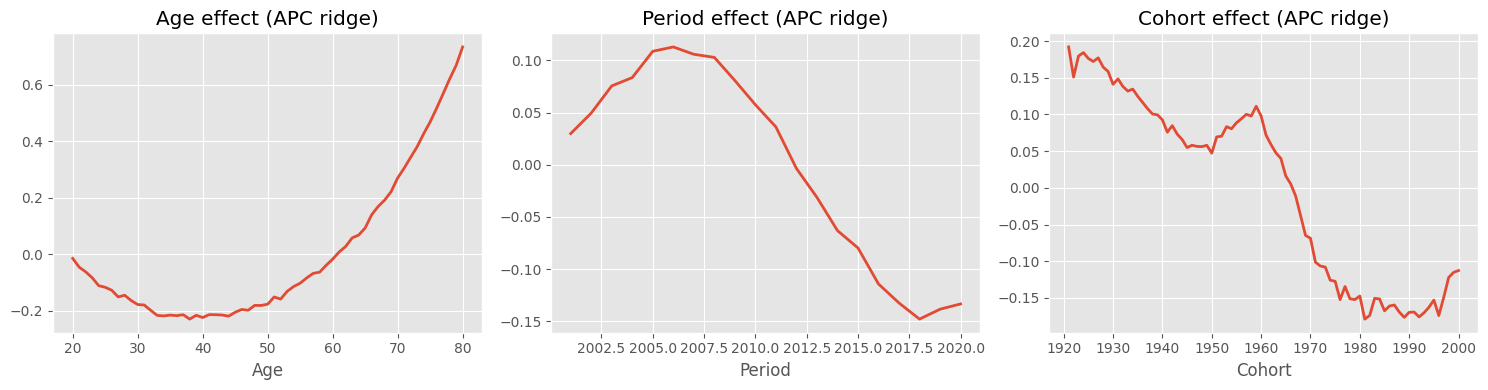

In [55]:
# Full APC design without intercept; drop one level per factor automatically
X_apc = dmatrix("0 + C(age) + C(period) + C(cohort)", grid, return_type='dataframe')

# Regularized Poisson GLM (elastic-net with L1_wt=0 -> pure ridge)
# alpha controls penalty strength; tune it (e.g., try 0.1, 0.5, 1.0, 5.0)
alpha = 1
model_apc = sm.GLM(y, X_apc, family=sm.families.Poisson(), offset=offset)
res_apc = model_apc.fit_regularized(alpha=alpha, L1_wt=0.0, maxiter=2000)

# Recover and center effects for plotting
age_cols2 = [c for c in X_apc.columns if c.startswith('C(age)')]
per_cols2 = [c for c in X_apc.columns if c.startswith('C(period)')]
coh_cols2 = [c for c in X_apc.columns if c.startswith('C(cohort)')]

def extract_center(params, cols, cast=int):
    indices = []
    for c in cols:
        # Extract value between brackets and remove 'T.' prefix if present
        val = c.split('[')[-1][:-1]
        if val.startswith('T.'):
            val = val[2:]
        indices.append(cast(val))
    
    s = pd.Series(params[cols].values, index=indices).sort_index()
    return s - s.mean()

age_eff_hat_apc = extract_center(res_apc.params, age_cols2, cast=int)
per_eff_hat_apc = extract_center(res_apc.params, per_cols2, cast=int)
coh_eff_hat_apc = extract_center(res_apc.params, coh_cols2, cast=int)

fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(age_eff_hat_apc.index, age_eff_hat_apc.values, lw=2)
ax[0].set_title('Age effect (APC ridge)'); ax[0].set_xlabel('Age'); ax[0].grid(True)
ax[1].plot(per_eff_hat_apc.index, per_eff_hat_apc.values, lw=2)
ax[1].set_title('Period effect (APC ridge)'); ax[1].set_xlabel('Period'); ax[1].grid(True)
ax[2].plot(coh_eff_hat_apc.index, coh_eff_hat_apc.values, lw=2)
ax[2].set_title('Cohort effect (APC ridge)'); ax[2].set_xlabel('Cohort'); ax[2].grid(True)
plt.tight_layout(); plt.show()

In [52]:
grid['mu_apc'] = res_apc.predict(X_apc, offset=offset)
print("AP  - Poisson deviance:", res_ap.deviance)
# fit_regularized doesn’t always store deviance; compute a pseudo-deviance:
dev_apc = 2*np.sum(grid['count']*np.log((grid['count']+1e-12)/grid['mu_apc']) - (grid['count']-grid['mu_apc']))
print("APC ridge pseudo-deviance:", dev_apc)

resid_apc = (grid['count'] - grid['mu_apc'])/np.sqrt(np.maximum(grid['mu_apc'],1e-9))
resid_mat_apc = resid_apc.values.reshape(len(ages), len(periods), order='F')  # same shape as heatmaps if you like


AP  - Poisson deviance: 3344.5615372958455
APC ridge pseudo-deviance: 2089.3293415843955


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_eff, per_eff, coh_eff]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


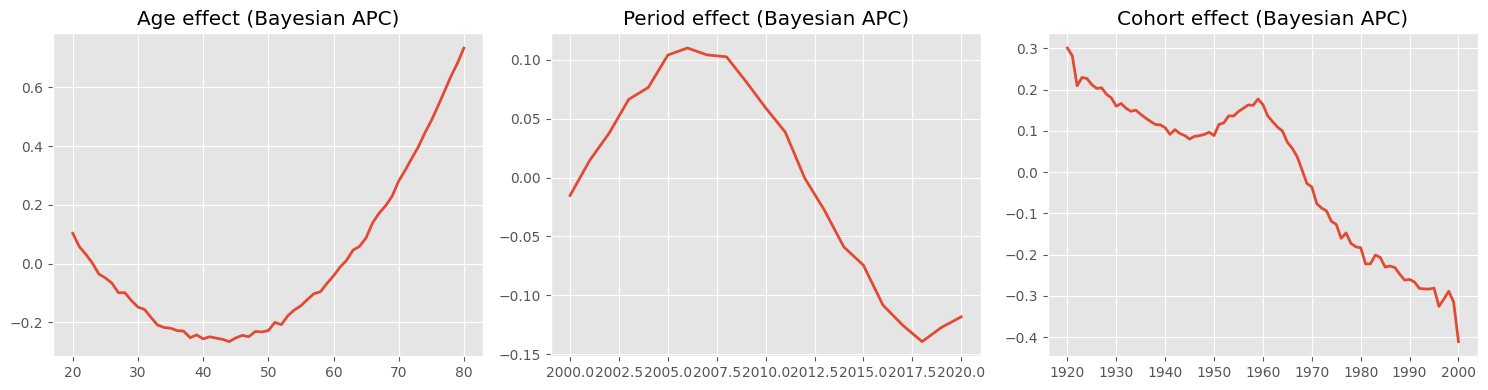

In [56]:
# OPTIONAL: Requires pymc >= 5, aesara/pytensor.
# pip install pymc
import pymc as pm

# Index maps
age_codes = pd.Categorical(grid['age']).codes
per_codes = pd.Categorical(grid['period']).codes
coh_codes = pd.Categorical(grid['cohort']).codes

with pm.Model() as apc_model:
    # RW2 priors via Gaussian on second differences
    def rw2(name, n, sigma=1.0):
        x = pm.Normal(name, 0.0, 1.0, shape=n)
        # soft RW2: encourage smoothness by penalizing second diff
        pm.Potential(name+"_rw2_prior", - (1/(2*sigma**2)) * pm.math.sum((x[2:] - 2*x[1:-1] + x[:-2])**2))
        # center to zero to break location invariance
        pm.Potential(name+"_sum_to_zero", -1e6*(pm.math.sum(x))**2)
        return x

    age_eff = rw2("age_eff", len(ages), sigma=1.0)
    per_eff = rw2("per_eff", len(periods), sigma=1.0)
    coh_eff = rw2("coh_eff", len(grid['cohort'].unique()), sigma=1.0)

    eta = (age_eff[age_codes] + per_eff[per_codes] + coh_eff[coh_codes] +
           np.log(grid['exposure'].values))

    mu = pm.math.exp(eta)
    count = pm.Poisson("count", mu, observed=grid['count'].values)

    idata = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, random_seed=123, progressbar=False)

age_post = idata.posterior['age_eff'].mean(dim=("chain","draw")).values
per_post = idata.posterior['per_eff'].mean(dim=("chain","draw")).values
coh_post = idata.posterior['coh_eff'].mean(dim=("chain","draw")).values

# Center for plotting
age_post -= age_post.mean(); per_post -= per_post.mean(); coh_post -= coh_post.mean()

fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(ages, age_post, lw=2); ax[0].set_title('Age effect (Bayesian APC)')
ax[1].plot(periods, per_post, lw=2); ax[1].set_title('Period effect (Bayesian APC)')
ax[2].plot(sorted(grid['cohort'].unique()), coh_post, lw=2); ax[2].set_title('Cohort effect (Bayesian APC)')
for a in ax: a.grid(True)
plt.tight_layout(); plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_eff, per_eff, coh_eff]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


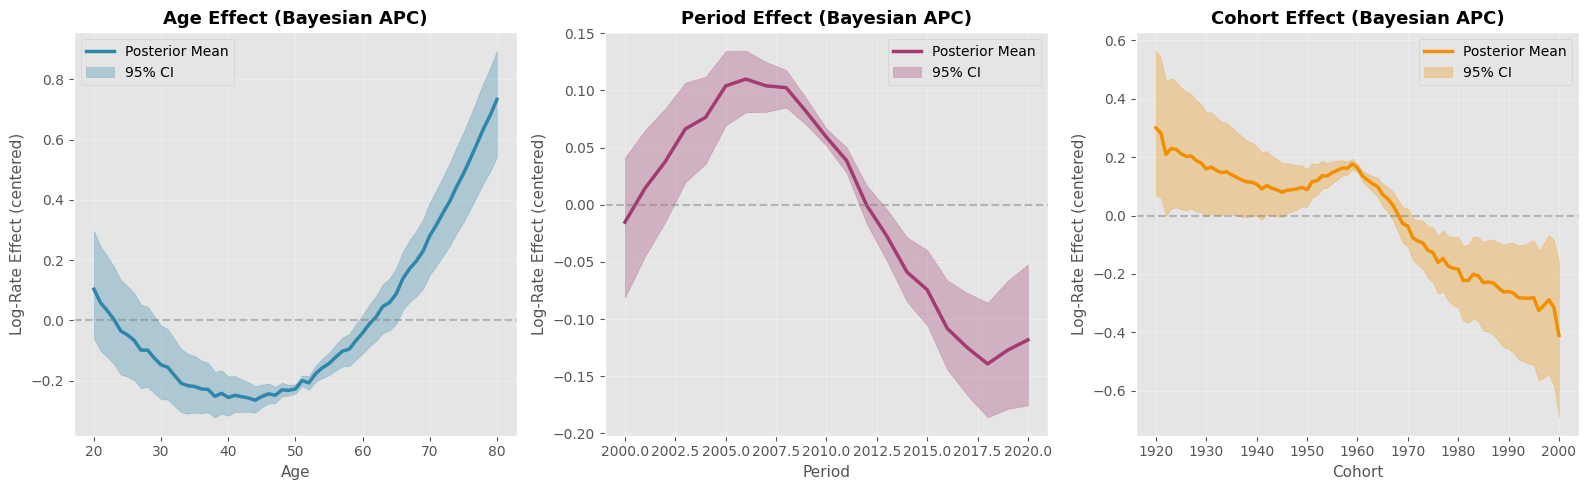

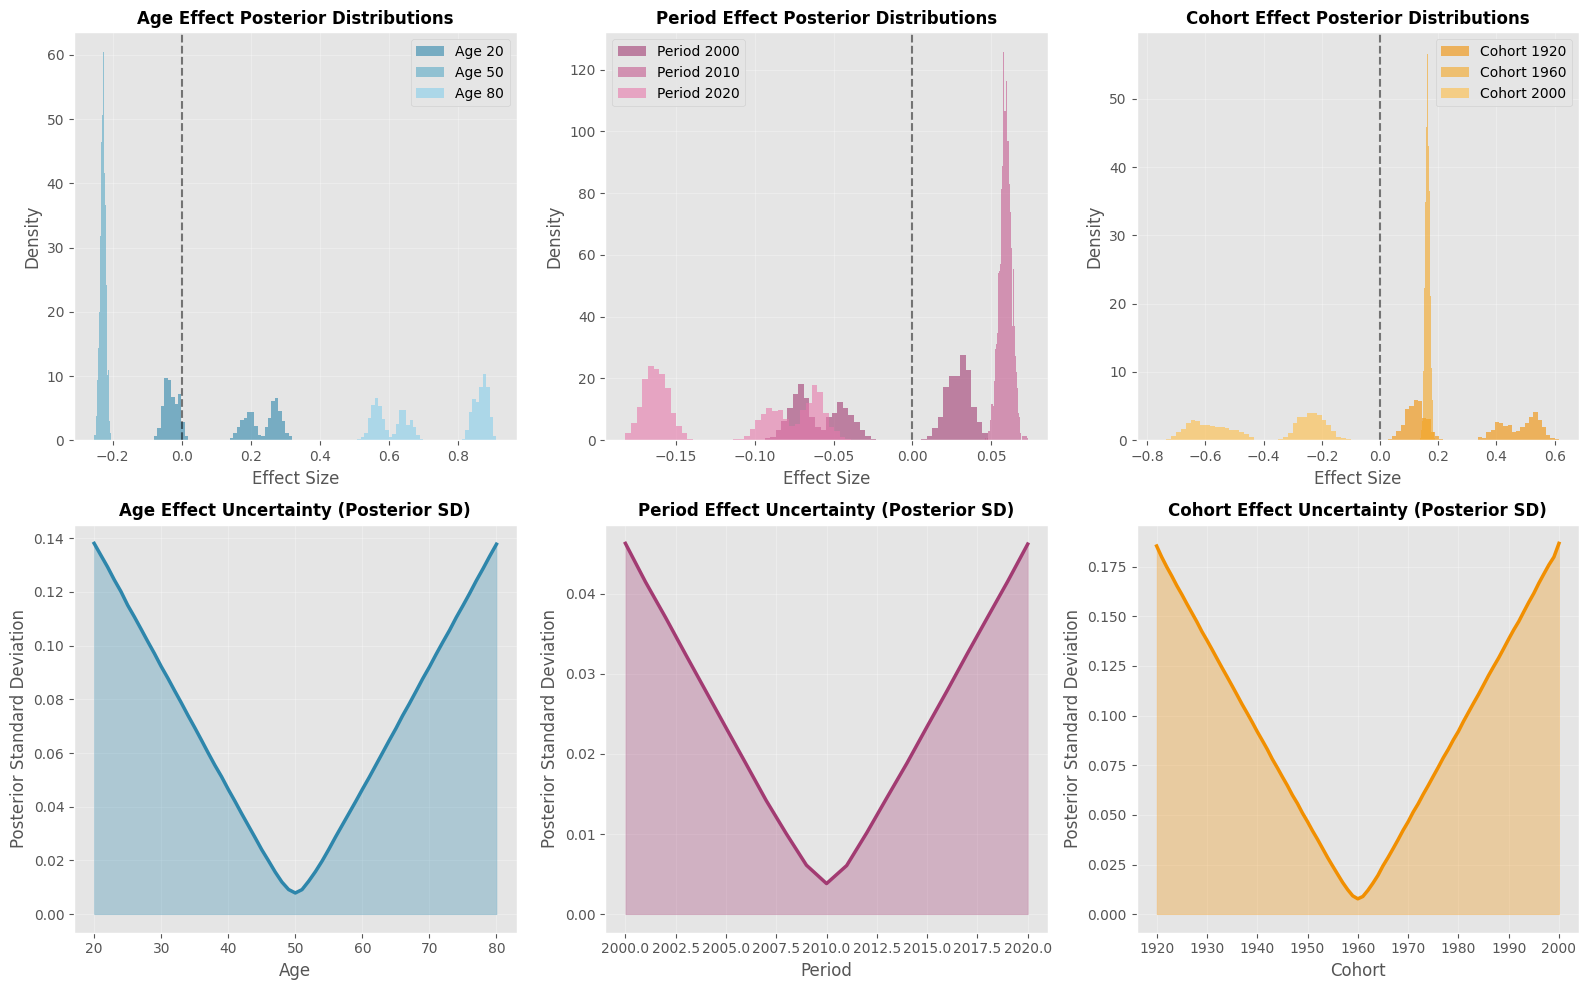

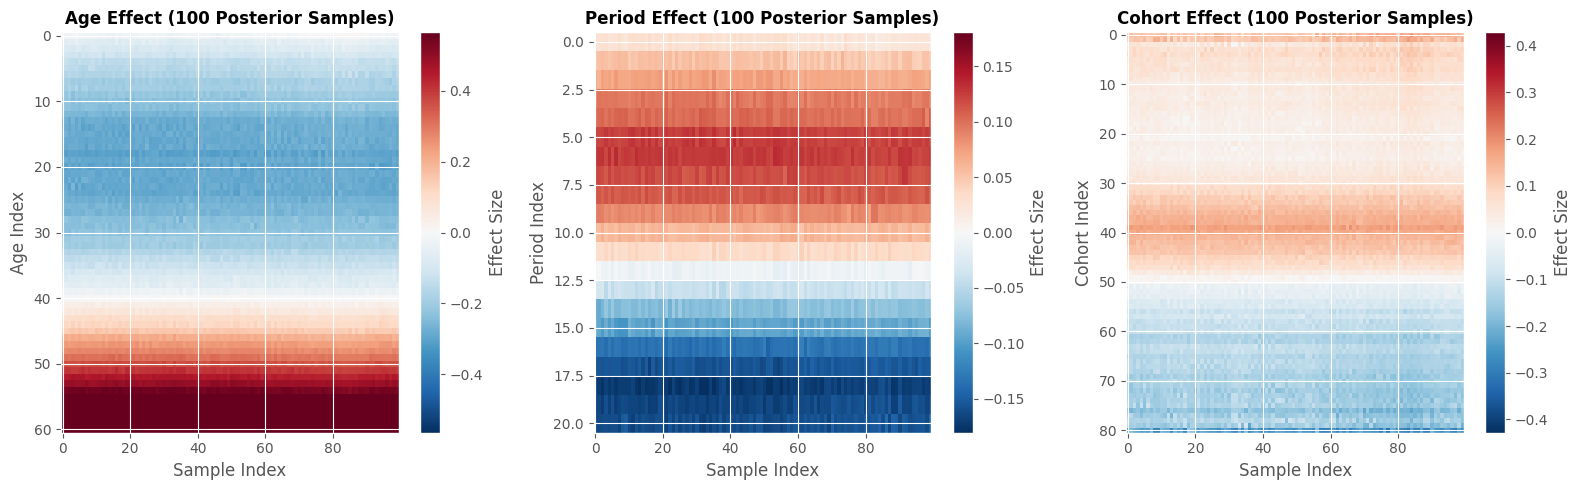


BAYESIAN APC MODEL - POSTERIOR SUMMARY STATISTICS

--- AGE EFFECTS ---
Mean effect range: [-0.265, 0.734]
Average uncertainty (SD): 0.071
Max uncertainty at age: 20

--- PERIOD EFFECTS ---
Mean effect range: [-0.139, 0.110]
Average uncertainty (SD): 0.025
Max uncertainty at period: 2000

--- COHORT EFFECTS ---
Mean effect range: [-0.411, 0.301]
Average uncertainty (SD): 0.094
Max uncertainty at cohort: 2000

--- EFFECT DIRECTION PROBABILITIES ---
Age effects mostly positive: 23/61 categories
Period effects mostly positive: 11/21 categories
Cohort effects mostly positive: 49/81 categories



In [58]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Index maps
age_codes = pd.Categorical(grid['age']).codes
per_codes = pd.Categorical(grid['period']).codes
coh_codes = pd.Categorical(grid['cohort']).codes

with pm.Model() as apc_model:
    # RW2 priors via Gaussian on second differences
    def rw2(name, n, sigma=1.0):
        x = pm.Normal(name, 0.0, 1.0, shape=n)
        # soft RW2: encourage smoothness by penalizing second diff
        pm.Potential(name+"_rw2_prior", - (1/(2*sigma**2)) * pm.math.sum((x[2:] - 2*x[1:-1] + x[:-2])**2))
        # center to zero to break location invariance
        pm.Potential(name+"_sum_to_zero", -1e6*(pm.math.sum(x))**2)
        return x
    
    age_eff = rw2("age_eff", len(ages), sigma=1.0)
    per_eff = rw2("per_eff", len(periods), sigma=1.0)
    coh_eff = rw2("coh_eff", len(grid['cohort'].unique()), sigma=1.0)
    
    eta = (age_eff[age_codes] + per_eff[per_codes] + coh_eff[coh_codes] +
           np.log(grid['exposure'].values))
    mu = pm.math.exp(eta)
    count = pm.Poisson("count", mu, observed=grid['count'].values)
    
    idata = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, random_seed=123, progressbar=False)

# Extract posterior samples
age_samples = idata.posterior['age_eff'].values.reshape(-1, len(ages))
per_samples = idata.posterior['per_eff'].values.reshape(-1, len(periods))
coh_samples = idata.posterior['coh_eff'].values.reshape(-1, len(grid['cohort'].unique()))

# Center each sample
age_samples = age_samples - age_samples.mean(axis=1, keepdims=True)
per_samples = per_samples - per_samples.mean(axis=1, keepdims=True)
coh_samples = coh_samples - coh_samples.mean(axis=1, keepdims=True)

# Compute statistics
age_mean = age_samples.mean(axis=0)
age_lower = np.percentile(age_samples, 2.5, axis=0)
age_upper = np.percentile(age_samples, 97.5, axis=0)

per_mean = per_samples.mean(axis=0)
per_lower = np.percentile(per_samples, 2.5, axis=0)
per_upper = np.percentile(per_samples, 97.5, axis=0)

coh_mean = coh_samples.mean(axis=0)
coh_lower = np.percentile(coh_samples, 2.5, axis=0)
coh_upper = np.percentile(coh_samples, 97.5, axis=0)

cohorts_sorted = sorted(grid['cohort'].unique())

# ============= MAIN EFFECTS PLOT WITH UNCERTAINTY =============
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# Age effect
ax[0].plot(ages, age_mean, lw=2.5, color='#2E86AB', label='Posterior Mean')
ax[0].fill_between(ages, age_lower, age_upper, alpha=0.3, color='#2E86AB', label='95% CI')
ax[0].axhline(0, ls='--', color='gray', alpha=0.5)
ax[0].set_title('Age Effect (Bayesian APC)', fontsize=13, fontweight='bold')
ax[0].set_xlabel('Age', fontsize=11)
ax[0].set_ylabel('Log-Rate Effect (centered)', fontsize=11)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Period effect
ax[1].plot(periods, per_mean, lw=2.5, color='#A23B72', label='Posterior Mean')
ax[1].fill_between(periods, per_lower, per_upper, alpha=0.3, color='#A23B72', label='95% CI')
ax[1].axhline(0, ls='--', color='gray', alpha=0.5)
ax[1].set_title('Period Effect (Bayesian APC)', fontsize=13, fontweight='bold')
ax[1].set_xlabel('Period', fontsize=11)
ax[1].set_ylabel('Log-Rate Effect (centered)', fontsize=11)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Cohort effect
ax[2].plot(cohorts_sorted, coh_mean, lw=2.5, color='#F18F01', label='Posterior Mean')
ax[2].fill_between(cohorts_sorted, coh_lower, coh_upper, alpha=0.3, color='#F18F01', label='95% CI')
ax[2].axhline(0, ls='--', color='gray', alpha=0.5)
ax[2].set_title('Cohort Effect (Bayesian APC)', fontsize=13, fontweight='bold')
ax[2].set_xlabel('Cohort', fontsize=11)
ax[2].set_ylabel('Log-Rate Effect (centered)', fontsize=11)
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============= POSTERIOR DISTRIBUTIONS =============
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

# Age effect distributions (sample a few ages)
sample_ages = [ages[0], ages[len(ages)//2], ages[-1]]
colors = ['#2E86AB', '#5AA9C6', '#87CEEB']
for i, (age_idx, age_val) in enumerate([(0, sample_ages[0]), 
                                          (len(ages)//2, sample_ages[1]), 
                                          (len(ages)-1, sample_ages[2])]):
    ax[0, 0].hist(age_samples[:, age_idx], bins=40, alpha=0.6, 
                  color=colors[i], label=f'Age {age_val}', density=True)
ax[0, 0].axvline(0, ls='--', color='black', alpha=0.5)
ax[0, 0].set_title('Age Effect Posterior Distributions', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Effect Size')
ax[0, 0].set_ylabel('Density')
ax[0, 0].legend()
ax[0, 0].grid(True, alpha=0.3)

# Period effect distributions
sample_periods = [periods[0], periods[len(periods)//2], periods[-1]]
colors_per = ['#A23B72', '#C55A8F', '#E779AC']
for i, (per_idx, per_val) in enumerate([(0, sample_periods[0]), 
                                         (len(periods)//2, sample_periods[1]), 
                                         (len(periods)-1, sample_periods[2])]):
    ax[0, 1].hist(per_samples[:, per_idx], bins=40, alpha=0.6, 
                  color=colors_per[i], label=f'Period {per_val}', density=True)
ax[0, 1].axvline(0, ls='--', color='black', alpha=0.5)
ax[0, 1].set_title('Period Effect Posterior Distributions', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Effect Size')
ax[0, 1].set_ylabel('Density')
ax[0, 1].legend()
ax[0, 1].grid(True, alpha=0.3)

# Cohort effect distributions
sample_cohorts_idx = [0, len(cohorts_sorted)//2, len(cohorts_sorted)-1]
colors_coh = ['#F18F01', '#F5A623', '#FFBD45']
for i, coh_idx in enumerate(sample_cohorts_idx):
    ax[0, 2].hist(coh_samples[:, coh_idx], bins=40, alpha=0.6, 
                  color=colors_coh[i], label=f'Cohort {cohorts_sorted[coh_idx]}', density=True)
ax[0, 2].axvline(0, ls='--', color='black', alpha=0.5)
ax[0, 2].set_title('Cohort Effect Posterior Distributions', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Effect Size')
ax[0, 2].set_ylabel('Density')
ax[0, 2].legend()
ax[0, 2].grid(True, alpha=0.3)

# ============= UNCERTAINTY QUANTIFICATION =============
# Age effect uncertainty (standard deviation across posterior)
age_std = age_samples.std(axis=0)
ax[1, 0].plot(ages, age_std, lw=2.5, color='#2E86AB')
ax[1, 0].fill_between(ages, 0, age_std, alpha=0.3, color='#2E86AB')
ax[1, 0].set_title('Age Effect Uncertainty (Posterior SD)', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Age')
ax[1, 0].set_ylabel('Posterior Standard Deviation')
ax[1, 0].grid(True, alpha=0.3)

# Period effect uncertainty
per_std = per_samples.std(axis=0)
ax[1, 1].plot(periods, per_std, lw=2.5, color='#A23B72')
ax[1, 1].fill_between(periods, 0, per_std, alpha=0.3, color='#A23B72')
ax[1, 1].set_title('Period Effect Uncertainty (Posterior SD)', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Period')
ax[1, 1].set_ylabel('Posterior Standard Deviation')
ax[1, 1].grid(True, alpha=0.3)

# Cohort effect uncertainty
coh_std = coh_samples.std(axis=0)
ax[1, 2].plot(cohorts_sorted, coh_std, lw=2.5, color='#F18F01')
ax[1, 2].fill_between(cohorts_sorted, 0, coh_std, alpha=0.3, color='#F18F01')
ax[1, 2].set_title('Cohort Effect Uncertainty (Posterior SD)', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('Cohort')
ax[1, 2].set_ylabel('Posterior Standard Deviation')
ax[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============= HEATMAP OF EFFECTS =============
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# Age effect heatmap over samples
im0 = ax[0].imshow(age_samples[:100, :].T, aspect='auto', cmap='RdBu_r', 
                    vmin=-age_samples.std()*2, vmax=age_samples.std()*2)
ax[0].set_title('Age Effect (100 Posterior Samples)', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Age Index')
plt.colorbar(im0, ax=ax[0], label='Effect Size')

# Period effect heatmap
im1 = ax[1].imshow(per_samples[:100, :].T, aspect='auto', cmap='RdBu_r',
                    vmin=-per_samples.std()*2, vmax=per_samples.std()*2)
ax[1].set_title('Period Effect (100 Posterior Samples)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Period Index')
plt.colorbar(im1, ax=ax[1], label='Effect Size')

# Cohort effect heatmap
im2 = ax[2].imshow(coh_samples[:100, :].T, aspect='auto', cmap='RdBu_r',
                    vmin=-coh_samples.std()*2, vmax=coh_samples.std()*2)
ax[2].set_title('Cohort Effect (100 Posterior Samples)', fontsize=12, fontweight='bold')
ax[2].set_xlabel('Sample Index')
ax[2].set_ylabel('Cohort Index')
plt.colorbar(im2, ax=ax[2], label='Effect Size')

plt.tight_layout()
plt.show()

# ============= SUMMARY STATISTICS =============
print("\n" + "="*70)
print("BAYESIAN APC MODEL - POSTERIOR SUMMARY STATISTICS")
print("="*70)

print("\n--- AGE EFFECTS ---")
print(f"Mean effect range: [{age_mean.min():.3f}, {age_mean.max():.3f}]")
print(f"Average uncertainty (SD): {age_std.mean():.3f}")
print(f"Max uncertainty at age: {ages[age_std.argmax()]}")

print("\n--- PERIOD EFFECTS ---")
print(f"Mean effect range: [{per_mean.min():.3f}, {per_mean.max():.3f}]")
print(f"Average uncertainty (SD): {per_std.mean():.3f}")
print(f"Max uncertainty at period: {periods[per_std.argmax()]}")

print("\n--- COHORT EFFECTS ---")
print(f"Mean effect range: [{coh_mean.min():.3f}, {coh_mean.max():.3f}]")
print(f"Average uncertainty (SD): {coh_std.mean():.3f}")
print(f"Max uncertainty at cohort: {cohorts_sorted[coh_std.argmax()]}")

# Probability of positive/negative effects
print("\n--- EFFECT DIRECTION PROBABILITIES ---")
print(f"Age effects mostly positive: {(age_mean > 0).sum()}/{len(ages)} categories")
print(f"Period effects mostly positive: {(per_mean > 0).sum()}/{len(periods)} categories")
print(f"Cohort effects mostly positive: {(coh_mean > 0).sum()}/{len(cohorts_sorted)} categories")

print("\n" + "="*70)